# Data SAO 159063

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

import scipy.special as sc
from scipy.interpolate import interp1d
from astropy import units as u
from skyfield.api import load
import pymc as pm
import arviz as az

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

az.style.use("arviz-darkgrid")
# plt.style.use(['science', 'notebook'])
# plt.style.use(['science', 'notebook', 'grid'])
pd.set_option('display.float_format',  '{:}'.format)

In [2]:
df = pd.read_csv("sao-159063.csv", sep=',')
df.head()

FrameNum            timeInfo  signal-stack  appsum-stack  avgbkg-stack  \
0    4500.0  [17:34:45.8421095]       35885.0     2165712.0      14294.14   
1    4501.0  [17:34:45.8522091]       23481.0     2144576.0      14235.54   
2    4502.0  [17:34:45.8623086]       38426.0     2157088.0       14219.2   
3    4503.0  [17:34:45.8724082]       22565.0     2142864.0      14230.19   
4    4504.0  [17:34:45.8825077]       41895.0     2165312.0      14251.12   

   stdbkg-stack  nmaskpx-stack  maxpx-stack  xcentroid-stack  ycentroid-stack  
0        1071.1           -149        18880            362.0            246.0  
1        993.38           -149        18336            362.0            246.0  
2        999.84           -149        18496            362.0            246.0  
3       1002.09           -149        17376            362.0            246.0  
4       1058.88           -149        18336            362.0            246.0

In [3]:
# hilangkan karakter [ dan ] dari data
df['timeInfo'] = df['timeInfo'].map((lambda x: x.lstrip('[').rstrip(']')))

# ubah ke format waktu dan ambil tanggal dan jamnya
df['timeInfo'] = pd.to_datetime(df['timeInfo'])

df.head()

FrameNum                   timeInfo  signal-stack  appsum-stack  \
0    4500.0 2022-07-27 17:34:45.842109       35885.0     2165712.0   
1    4501.0 2022-07-27 17:34:45.852209       23481.0     2144576.0   
2    4502.0 2022-07-27 17:34:45.862308       38426.0     2157088.0   
3    4503.0 2022-07-27 17:34:45.872408       22565.0     2142864.0   
4    4504.0 2022-07-27 17:34:45.882507       41895.0     2165312.0   

   avgbkg-stack  stdbkg-stack  nmaskpx-stack  maxpx-stack  xcentroid-stack  \
0      14294.14        1071.1           -149        18880            362.0   
1      14235.54        993.38           -149        18336            362.0   
2       14219.2        999.84           -149        18496            362.0   
3      14230.19       1002.09           -149        17376            362.0   
4      14251.12       1058.88           -149        18336            362.0   

   ycentroid-stack  
0            246.0  
1            246.0  
2            246.0  
3            246.0  
4            246.0

In [4]:
data = df[['FrameNum','timeInfo','signal-stack']]
data.columns = ['Frame','Date', 'Value']
data.head()

Frame                       Date   Value
0 4500.0 2022-07-27 17:34:45.842109 35885.0
1 4501.0 2022-07-27 17:34:45.852209 23481.0
2 4502.0 2022-07-27 17:34:45.862308 38426.0
3 4503.0 2022-07-27 17:34:45.872408 22565.0
4 4504.0 2022-07-27 17:34:45.882507 41895.0

In [5]:
data_copy = data.copy() # buat copy dari dataframe asli

data_copy['JD'] = Time(data_copy['Date']).jd

data_copy['frac_JD'] = data_copy['JD'] - np.floor(data_copy['JD']).astype(int)
data_copy

Frame                       Date    Value                 JD  \
0   4500.0 2022-07-27 17:34:45.842109  35885.0  2459788.232475024   
1   4501.0 2022-07-27 17:34:45.852209  23481.0 2459788.2324751415   
2   4502.0 2022-07-27 17:34:45.862308  38426.0 2459788.2324752584   
3   4503.0 2022-07-27 17:34:45.872408  22565.0 2459788.2324753753   
4   4504.0 2022-07-27 17:34:45.882507  41895.0  2459788.232475492   
..     ...                        ...      ...                ...   
896 5396.0 2022-07-27 17:34:54.891340 -13344.0 2459788.2325797607   
897 5397.0 2022-07-27 17:34:54.901440  -6075.0 2459788.2325798776   
898 5398.0 2022-07-27 17:34:54.911539  -2152.0 2459788.2325799945   
899 5399.0 2022-07-27 17:34:54.921639  -8683.0 2459788.2325801114   
900 5400.0 2022-07-27 17:34:54.931739 -18392.0 2459788.2325802282   

                frac_JD  
0   0.23247502418234944  
1   0.23247514152899384  
2   0.23247525840997696  
3   0.23247537529096007  
4    0.2324754921719432  
..                  ...  
896  0.2325797607190907  
897 0.23257987760007381  
898 0.23257999448105693  
899 0.23258011136204004  
900 0.23258022824302316  

[901 rows x 5 columns]

Text(0.5, 0, 'Frames')

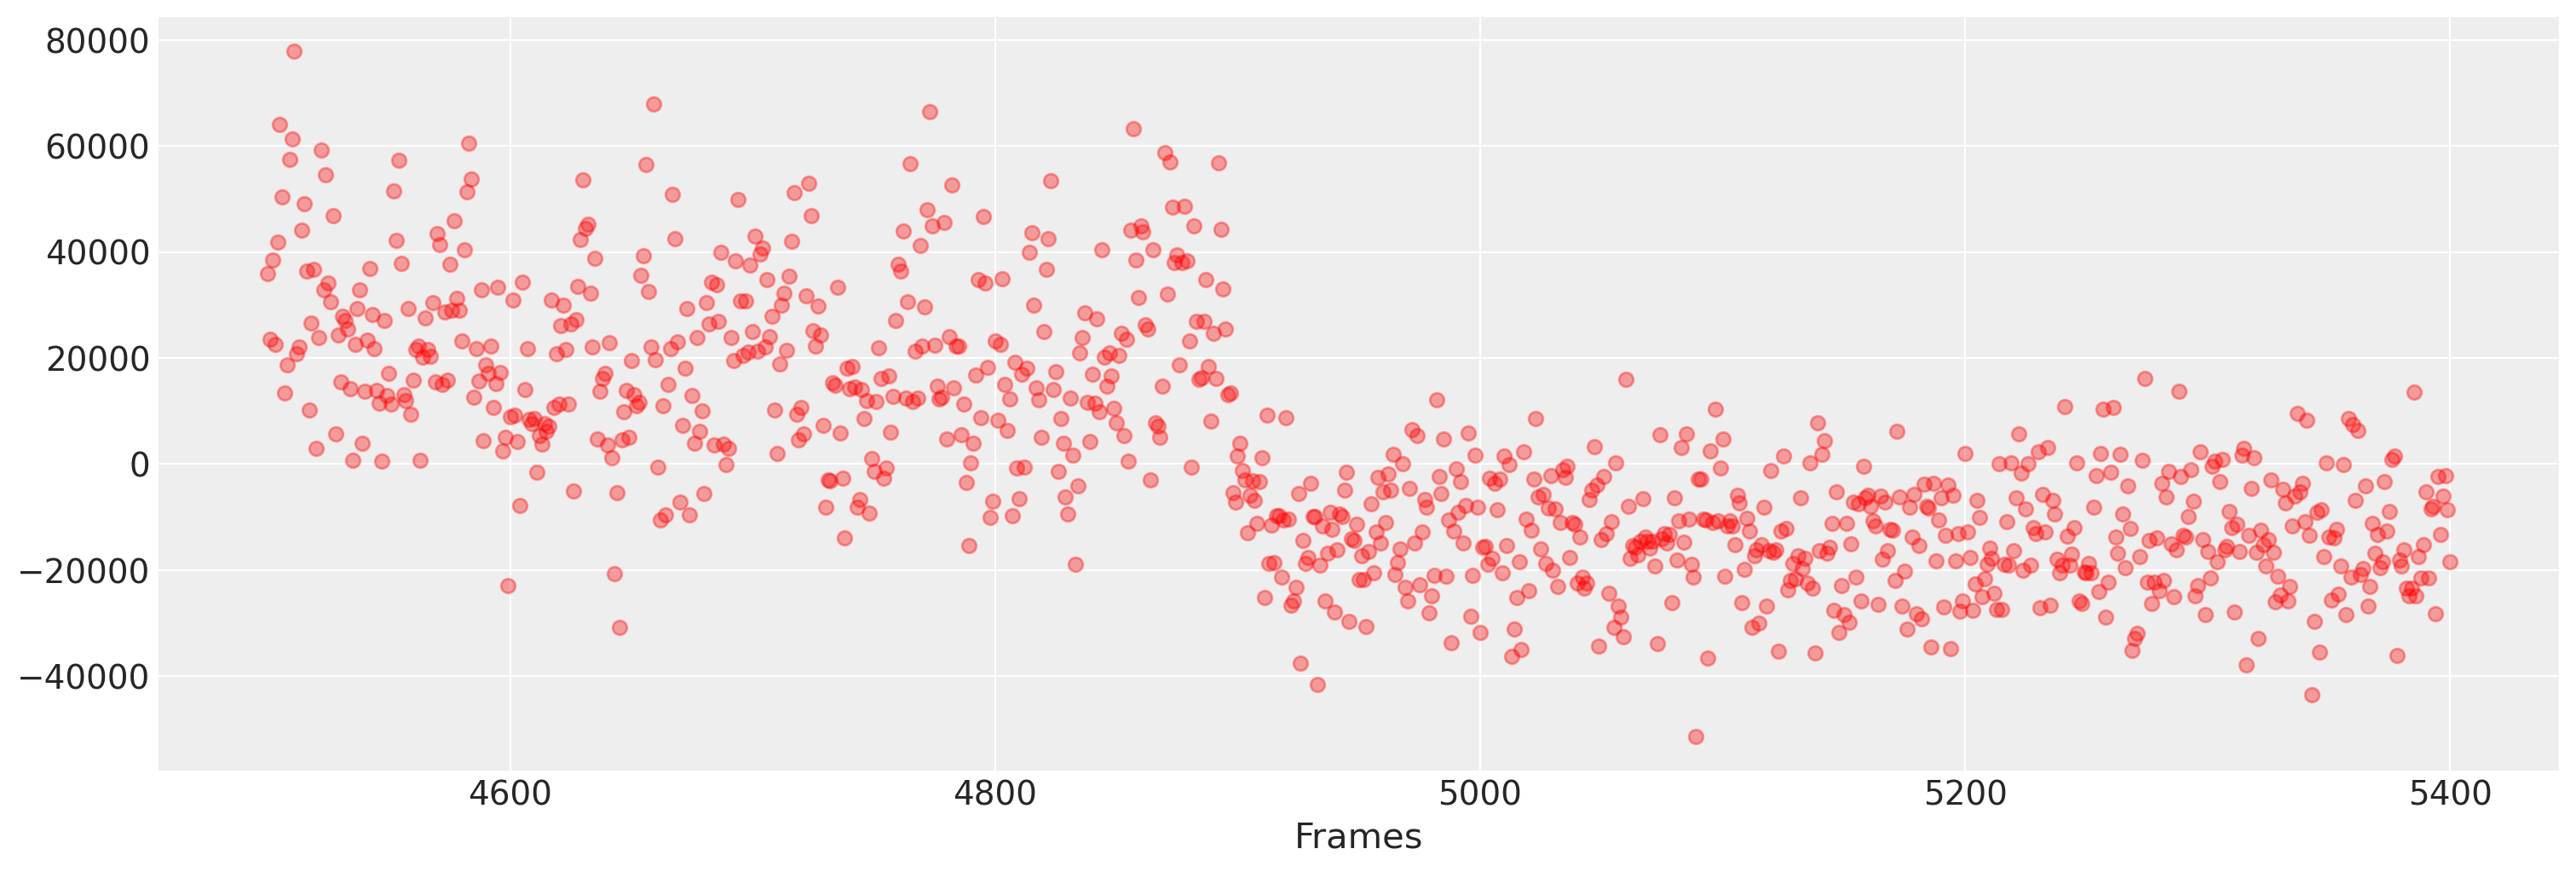

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data_copy['Frame'], data_copy['Value'], 'ro', alpha=0.35)
# ax.set_xlim(3300, 3700)
ax.set_xlabel('Frames')

### Normalisasi

In [7]:
data_copy['Value2'] = data_copy['Value'] + 20000
data_copy.head()

Frame                       Date   Value                 JD  \
0 4500.0 2022-07-27 17:34:45.842109 35885.0  2459788.232475024   
1 4501.0 2022-07-27 17:34:45.852209 23481.0 2459788.2324751415   
2 4502.0 2022-07-27 17:34:45.862308 38426.0 2459788.2324752584   
3 4503.0 2022-07-27 17:34:45.872408 22565.0 2459788.2324753753   
4 4504.0 2022-07-27 17:34:45.882507 41895.0  2459788.232475492   

              frac_JD  Value2  
0 0.23247502418234944 55885.0  
1 0.23247514152899384 43481.0  
2 0.23247525840997696 58426.0  
3 0.23247537529096007 42565.0  
4  0.2324754921719432 61895.0

In [8]:
value_scaled = data_copy['Value2']/(data_copy['Value2'].std()*2)

Text(0.5, 0, 'Frames')

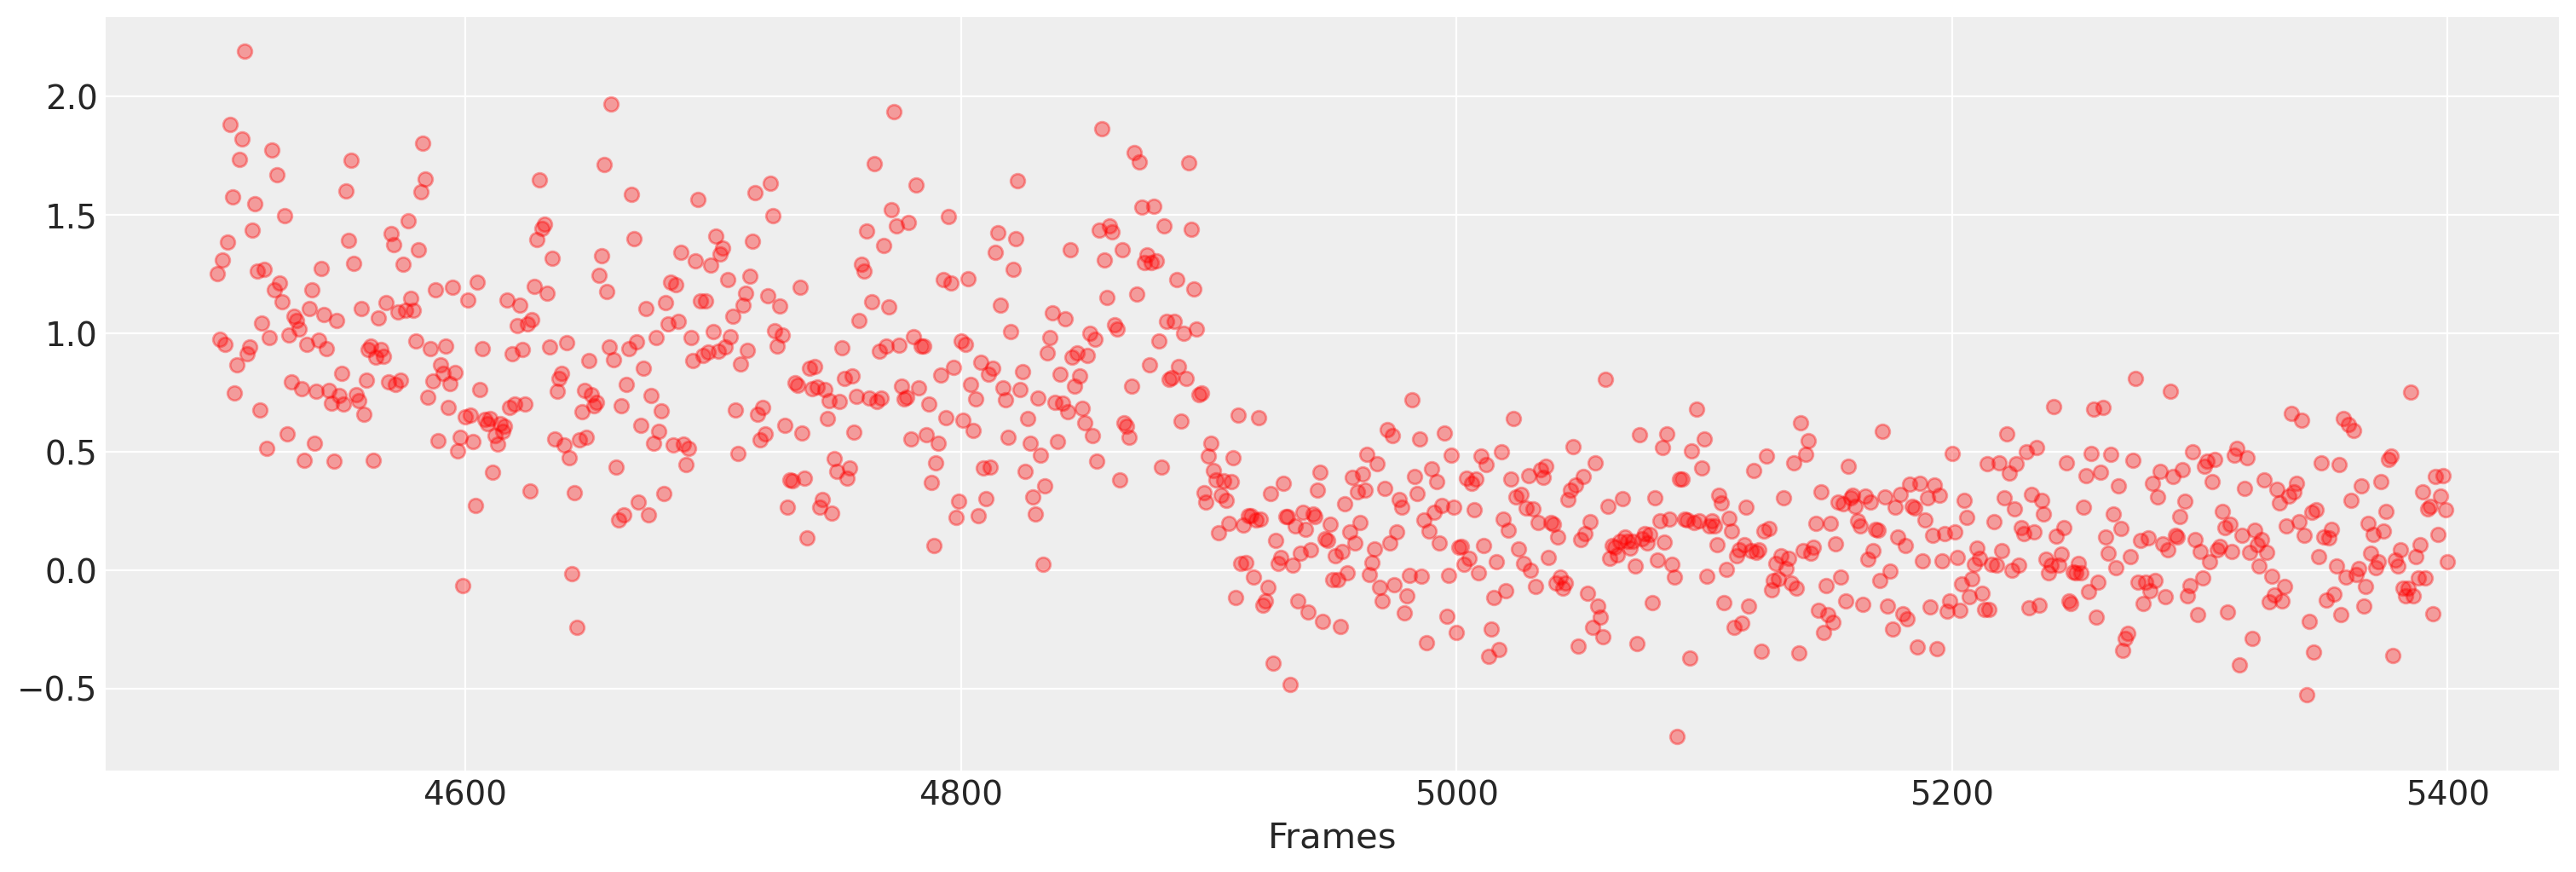

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(data['frac_JD'], value_scaled, 'ro', alpha=0.35)
ax.plot(data_copy['Frame'], value_scaled, 'ro', alpha=0.35)
ax.set_xlabel('Frames')

### Kurva Benda Hitam untuk SAO 159063

#### Cari temperatur efektif

Temperatur efektif bintang bisa didekati dengan persamaan yang menghubungkan indeks warna bintang, $B - V$ dengan temperatur efektif bintang, $T_\mathrm{eff}$. Persamaan yang digunakan dalam pekerjaan ini diadopsi dari pekerjaan **Ballesteros 2012** (https://arxiv.org/pdf/1201.1809.pdf) sebagai berikut:

$$
T_\mathrm{eff} =  4600\left(\frac{1}{0.92 (B-V) + 1.7} + \frac{1}{0.92 (B-V) + 0.62} \right)
$$

In [10]:
# Satuan t_eff adalah Kelvin

def ballesteros(bv):
    return 4600. * ((1./(0.92*bv + 1.7)) + (1./(0.92*bv + 0.62)))

In [11]:
b = 9.33
v = 8.02

bv = b - v

teff = ballesteros(bv)
teff

4103.639505412452

In [12]:
def Planck(λ, T): 
    """
    λ: dalam cm
    T: dalam K
    """
    a = 3.7412e-5 / ((λ * 1e-7) **5) # 1e-7 adalah konversi dari nm ke cm
    b = np.exp(1.43879/(λ * 1e-7 * T)) - 1
    return a/b

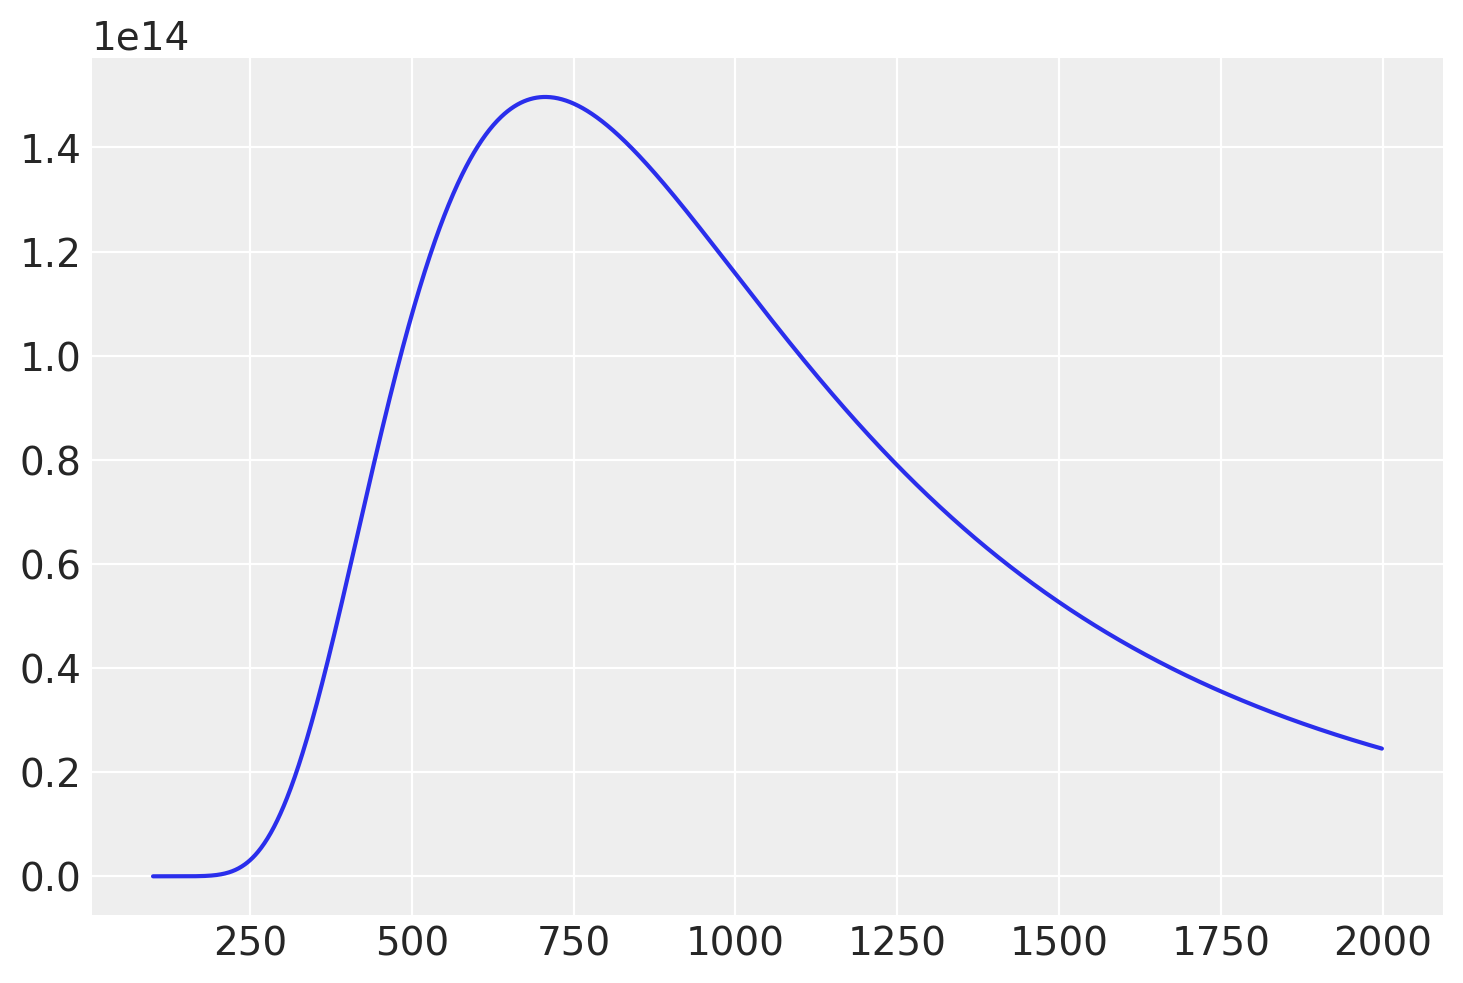

In [13]:
x_axis = np.arange(100, 2000)
y_axis = Planck(x_axis, teff)
plt.plot(x_axis, y_axis)

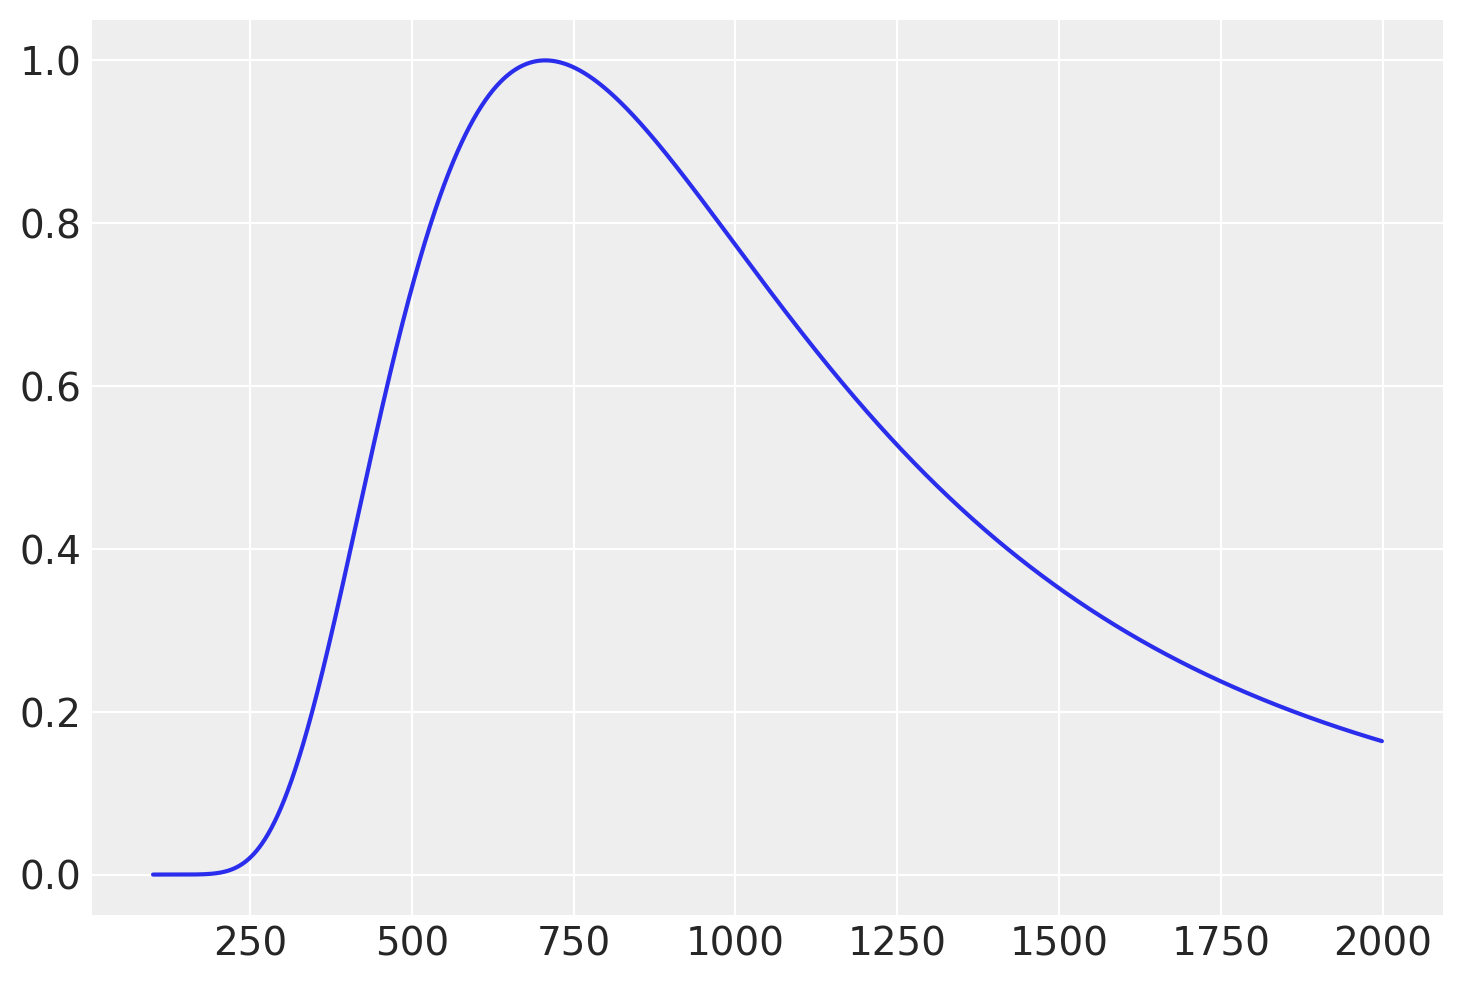

In [14]:
den = np.max(y_axis)

y_val = y_axis/den

plt.plot(x_axis, y_val)

### Kurva transmisi QHY 174M GPS *unfiltered*

In [15]:
df = pd.read_csv('qhy174_response.csv', delimiter=',', header='infer')
df.head()

wavelength  response
0       200.0       0.0
1       210.0       0.0
2       220.0       0.0
3       230.0       0.0
4       240.0       0.0

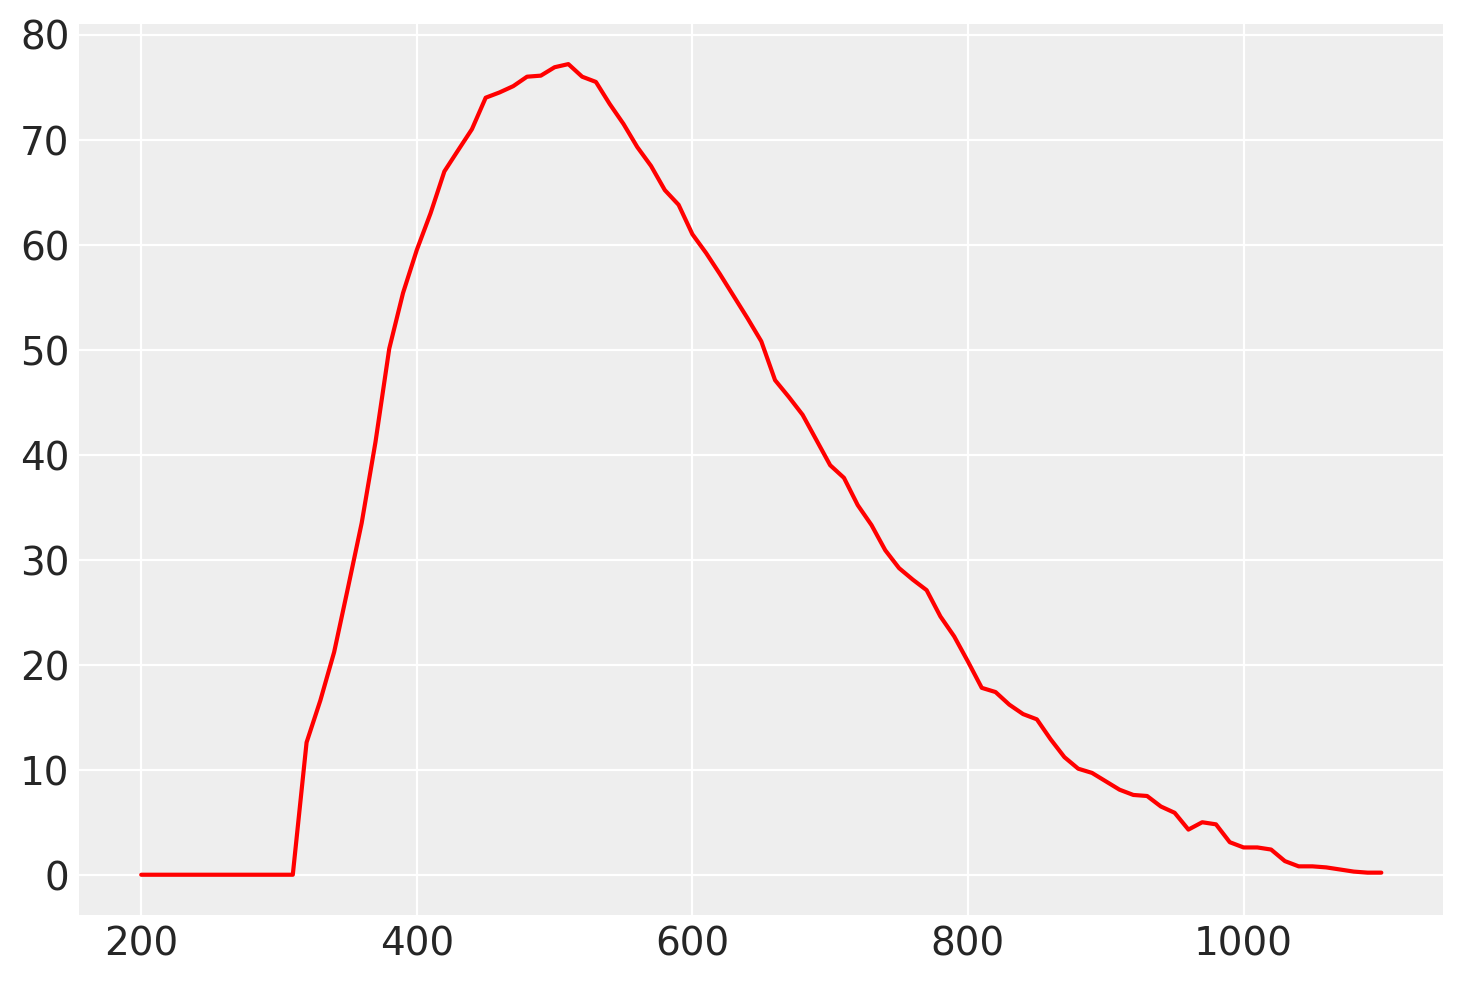

In [16]:
x = df['wavelength']
y = df['response']
plt.plot(x, y, 'r')

In [17]:
bandwidth = np.arange(330, 1100, 10) # rentang sesuai kurva transmisi

bandwidth

f_interp = interp1d(x, y, kind='cubic')

### Jarak Bulan saat pengamatan

Pengamatan dilakukan pada tanggal **9 Juli 2022 pukul 17:34:00.39 UT**

In [18]:
# load timescale dan tampilkan waktu saat ini
ts = load.timescale()

# custom waktu untuk yyyy, mm, dd, hh, mm, ss
t = ts.utc(2022, 7, 9, 17, 34, 0.39)

In [19]:
# Load the JPL ephemeris DE430 (covers 1549-2650) dan cari jarak Bumi-Bulan
planets = load('de430.bsp')
earth, moon = planets['earth'], planets['moon']

In [20]:
# posisi Bulan dari Bumi
astrometric = earth.at(t).observe(moon)
ra, dec, distance = astrometric.radec()

In [21]:
# tampilkan koordinat Bulan dan jarak Bulan dalam km
print(ra)
print(dec)
print(distance.km)

15h 13m 05.23s
-17deg 55' 58.8"
368539.0450032059


In [22]:
d_moon = distance.km
d_moon

368539.0450032059

### Inisiasi model

In [23]:
x_data = np.array(data_copy['Frame'])
y_data = np.array(data_copy['Value2'])

In [24]:
def fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        # model untuk disappearance
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        # y_new = f_interp(bandwidth[i]) * y
        y0 += y_new
    return y0

In [25]:
# Variabel benar
# -------------
x0_true = 4900
A_true = 1.
σ_true = 600
T = teff

In [26]:
y_syn = fresnel_polikromatik(x_data, x0_true, d_moon, A_true)
y_syn = np.random.normal(y_syn, scale=σ_true)

y_syn_scaled = y_syn / (y_syn.std()*2)

Text(0, 0.5, 'Intensity')

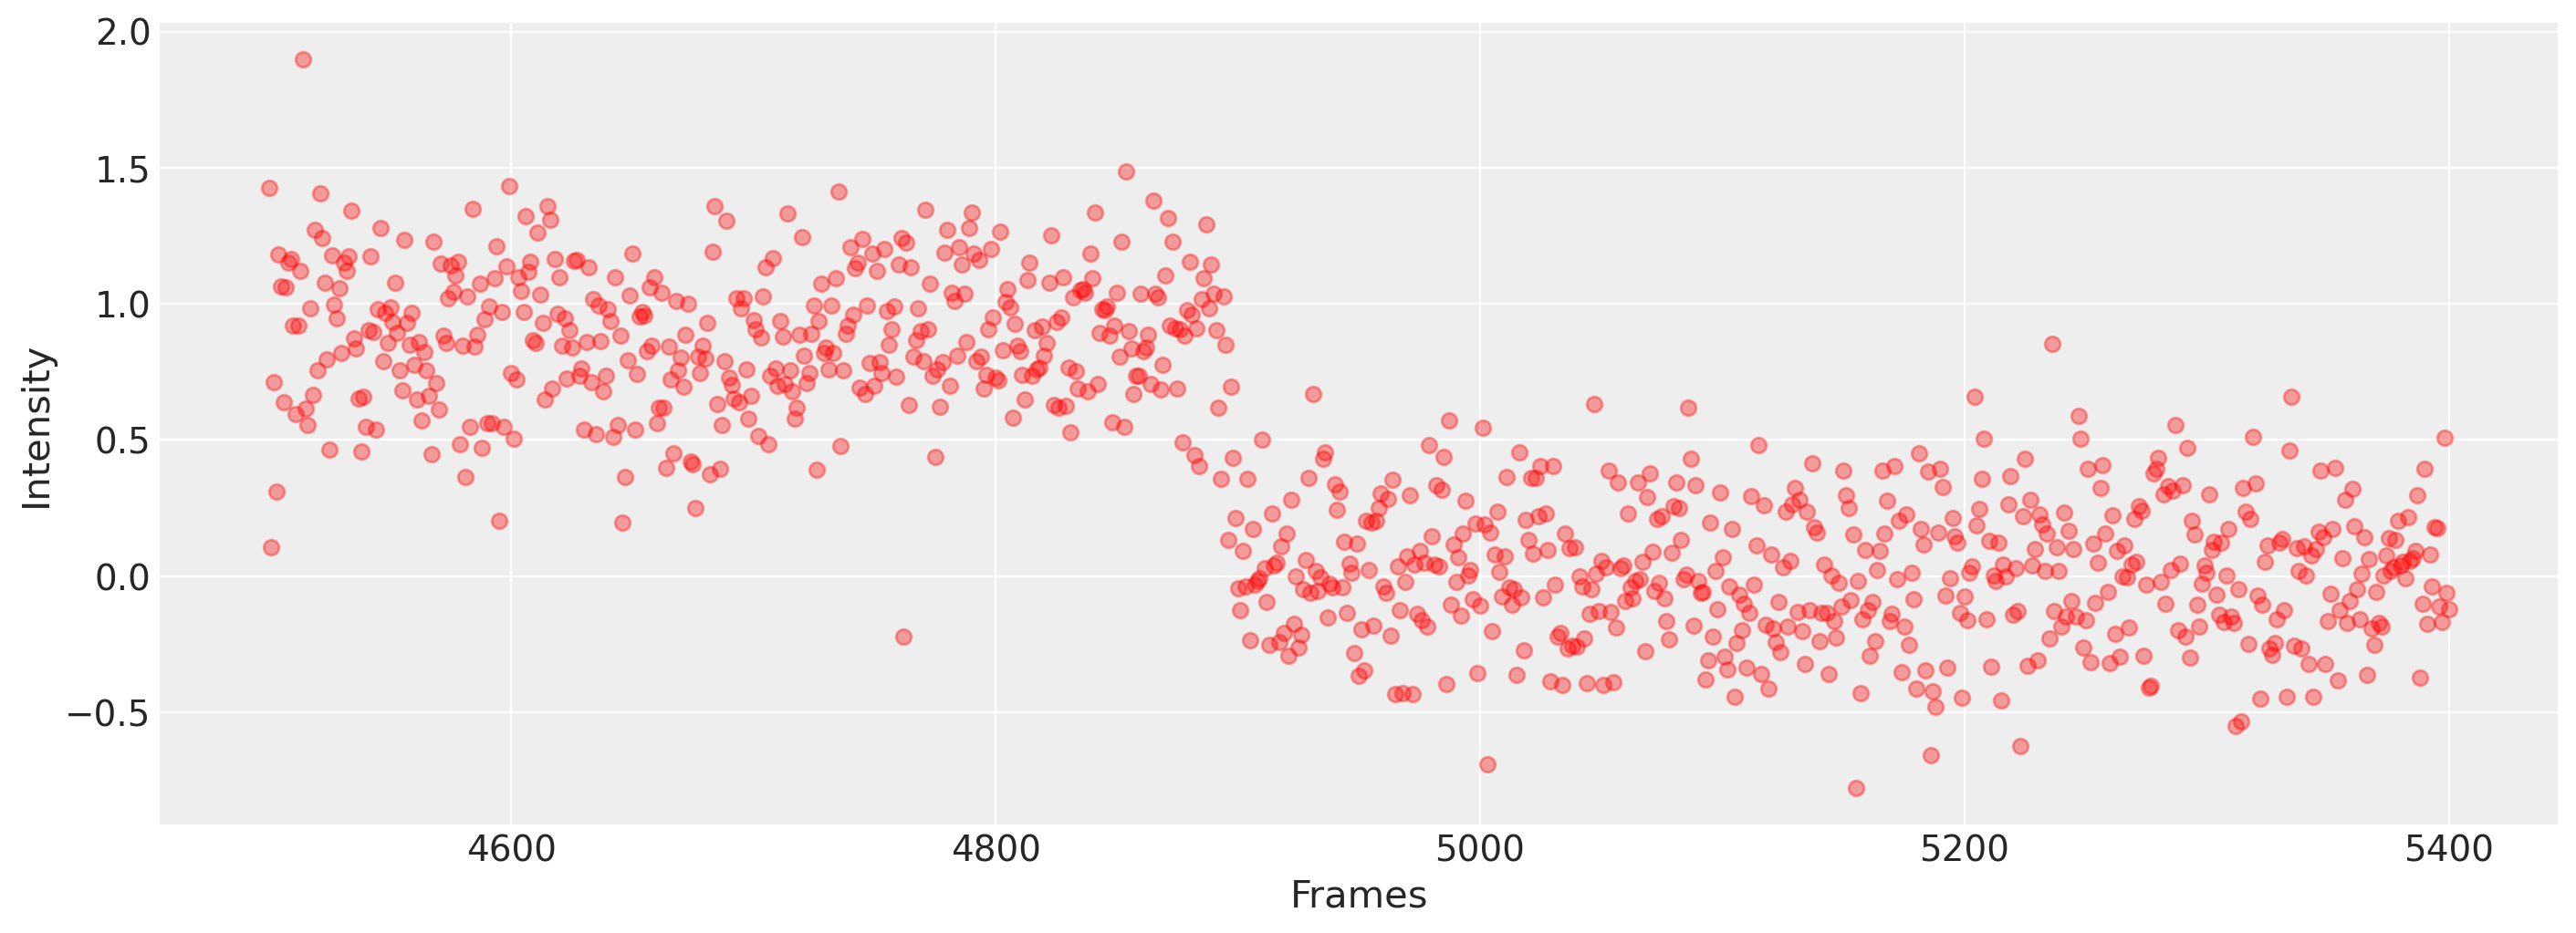

In [27]:
plt.figure(figsize = (14,5), facecolor='w')
plt.scatter(x_data, y_syn_scaled, marker='o', c='r', alpha=0.35)
plt.xlabel('Frames')
plt.ylabel('Intensity')

In [28]:
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_fresnel_polikromatik(x, x0, d, A):
    y0 = np.zeros(len(x))
    for i in range (len(bandwidth)):
        w = (x - x0) * np.sqrt(2 / (bandwidth[i] * d)) * np.sqrt(1. / 1e-6) # faktor konversi ke satuan meter
        cc, ss = sc.fresnel(-w)
        y = A * 0.5 * ((cc + 0.5)**2 + (ss + 0.5)**2)
        y_new = f_interp(bandwidth[i]) * (Planck(bandwidth[i], T)/den) * y
        y0 += y_new
    return y0

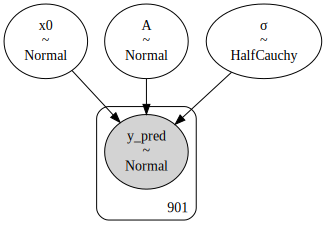

In [29]:
x_shared = aesara.shared(x_data)
d_shared = aesara.shared(d_moon)

with pm.Model() as model_polikromatik:
    A = pm.Normal('A', mu=1., sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=4900., sigma=1.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=value_scaled)
    
pm.model_to_graphviz(model_polikromatik)

In [30]:
with model_polikromatik:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1121 seconds.


In [31]:
az.summary(idata)

mean    sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
A       0.0   0.0      0.0      0.0        0.0      0.0    2032.0    1320.0   
x0 4901.956 0.769 4900.577 4903.519      0.018    0.012    1910.0    1527.0   
σ     0.336 0.008     0.32     0.35        0.0      0.0     934.0    1503.0   

    r_hat  
A     1.0  
x0    1.0  
σ     1.0

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

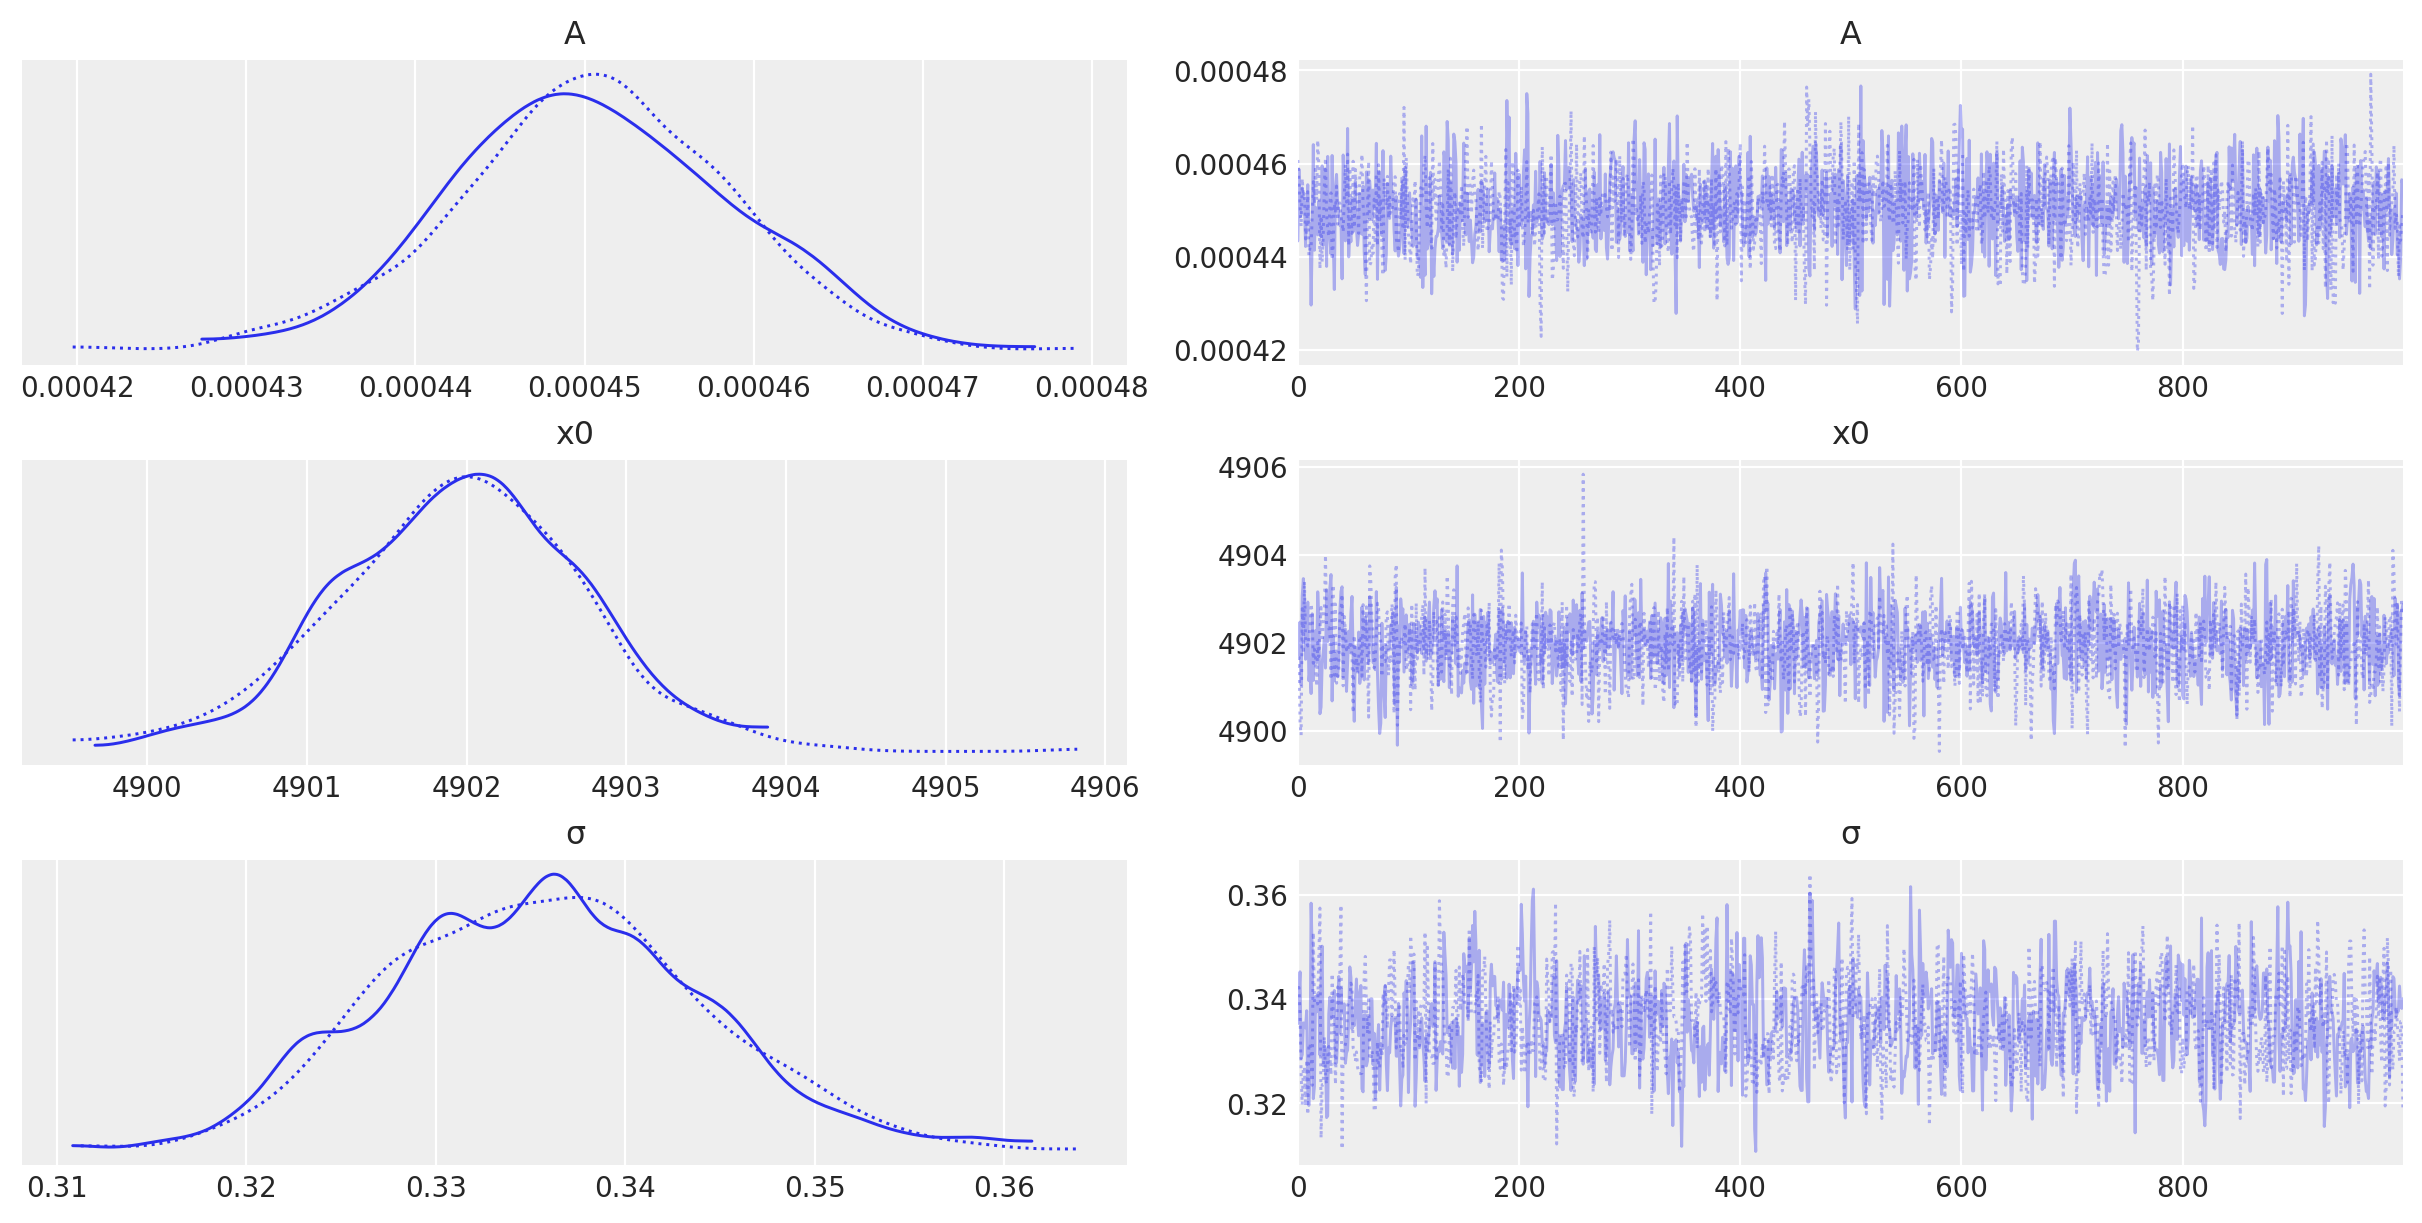

In [32]:
az.plot_trace(idata)

In [33]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

C:\Users\User\AppData\Local\Temp\ipykernel_3336\3398960922.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


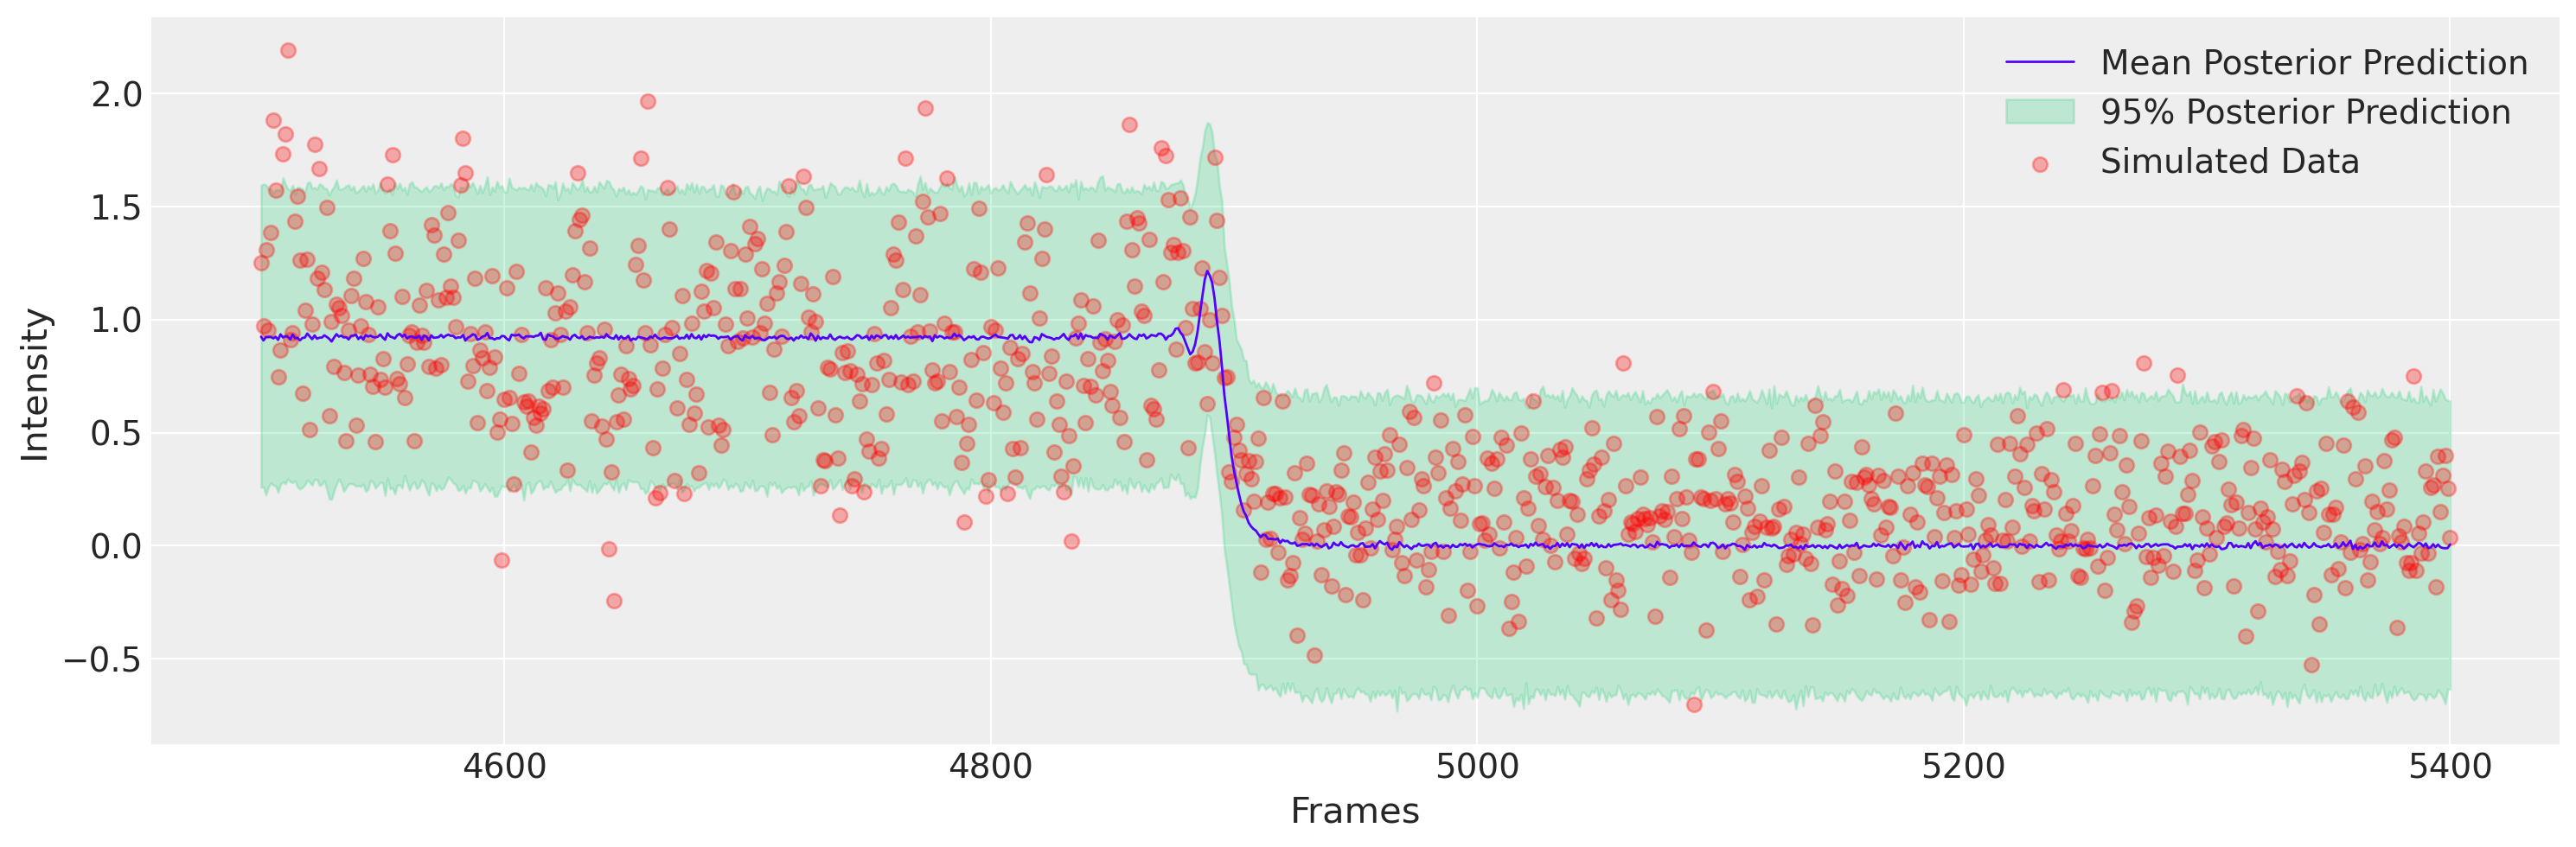

In [34]:
plt.figure(figsize=(15,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, value_scaled, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
# plt.xlim(3300, 3700)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper right')
# plt.savefig('hasil-kurvatransmisi-planck.png', dpi=150)

###  *Data smoothing*

In [35]:
from scipy.signal import savgol_filter

In [36]:
y_filtered = savgol_filter(value_scaled, 10, 2)

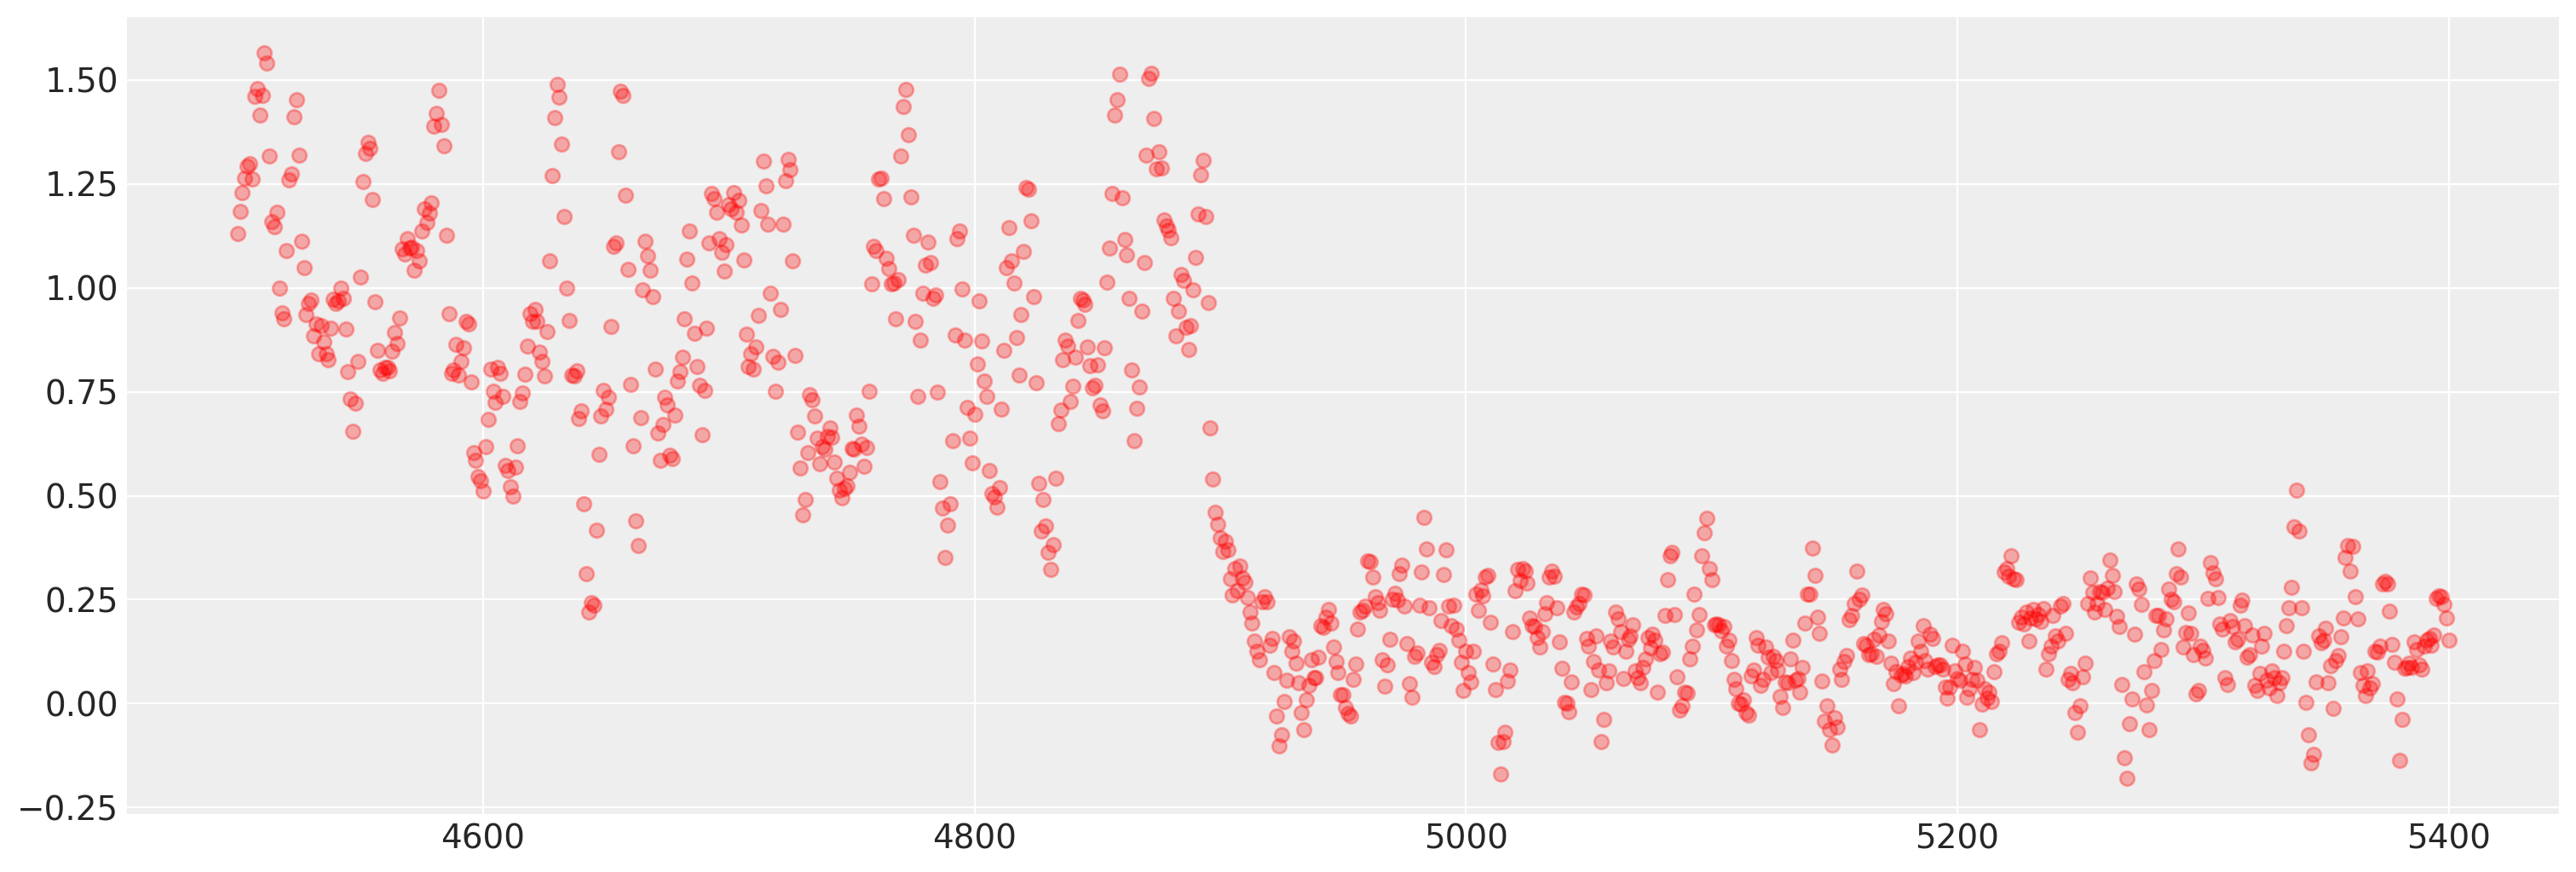

In [37]:
plt.figure(figsize=(15,5))
plt.scatter(x_data, y_filtered, c='r', marker='o', alpha=0.3)
# plt.xlim(3300, 3700)

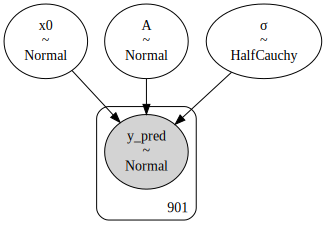

In [38]:
with pm.Model() as model_polikromatik_smt:
    A = pm.Normal('A', mu=1., sigma=1.)
    σ = pm.HalfCauchy('σ', beta=1.)
    x0 = pm.Normal('x0', mu=4900., sigma=1.)
    
    μ = t_fresnel_polikromatik(x_shared, x0, d_shared, A)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=σ, observed=y_filtered)
    
pm.model_to_graphviz(model_polikromatik_smt)

In [39]:
with model_polikromatik_smt:
    idata = pm.sample(cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [x0]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1225 seconds.


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'x0'}>,
        <AxesSubplot:title={'center':'x0'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

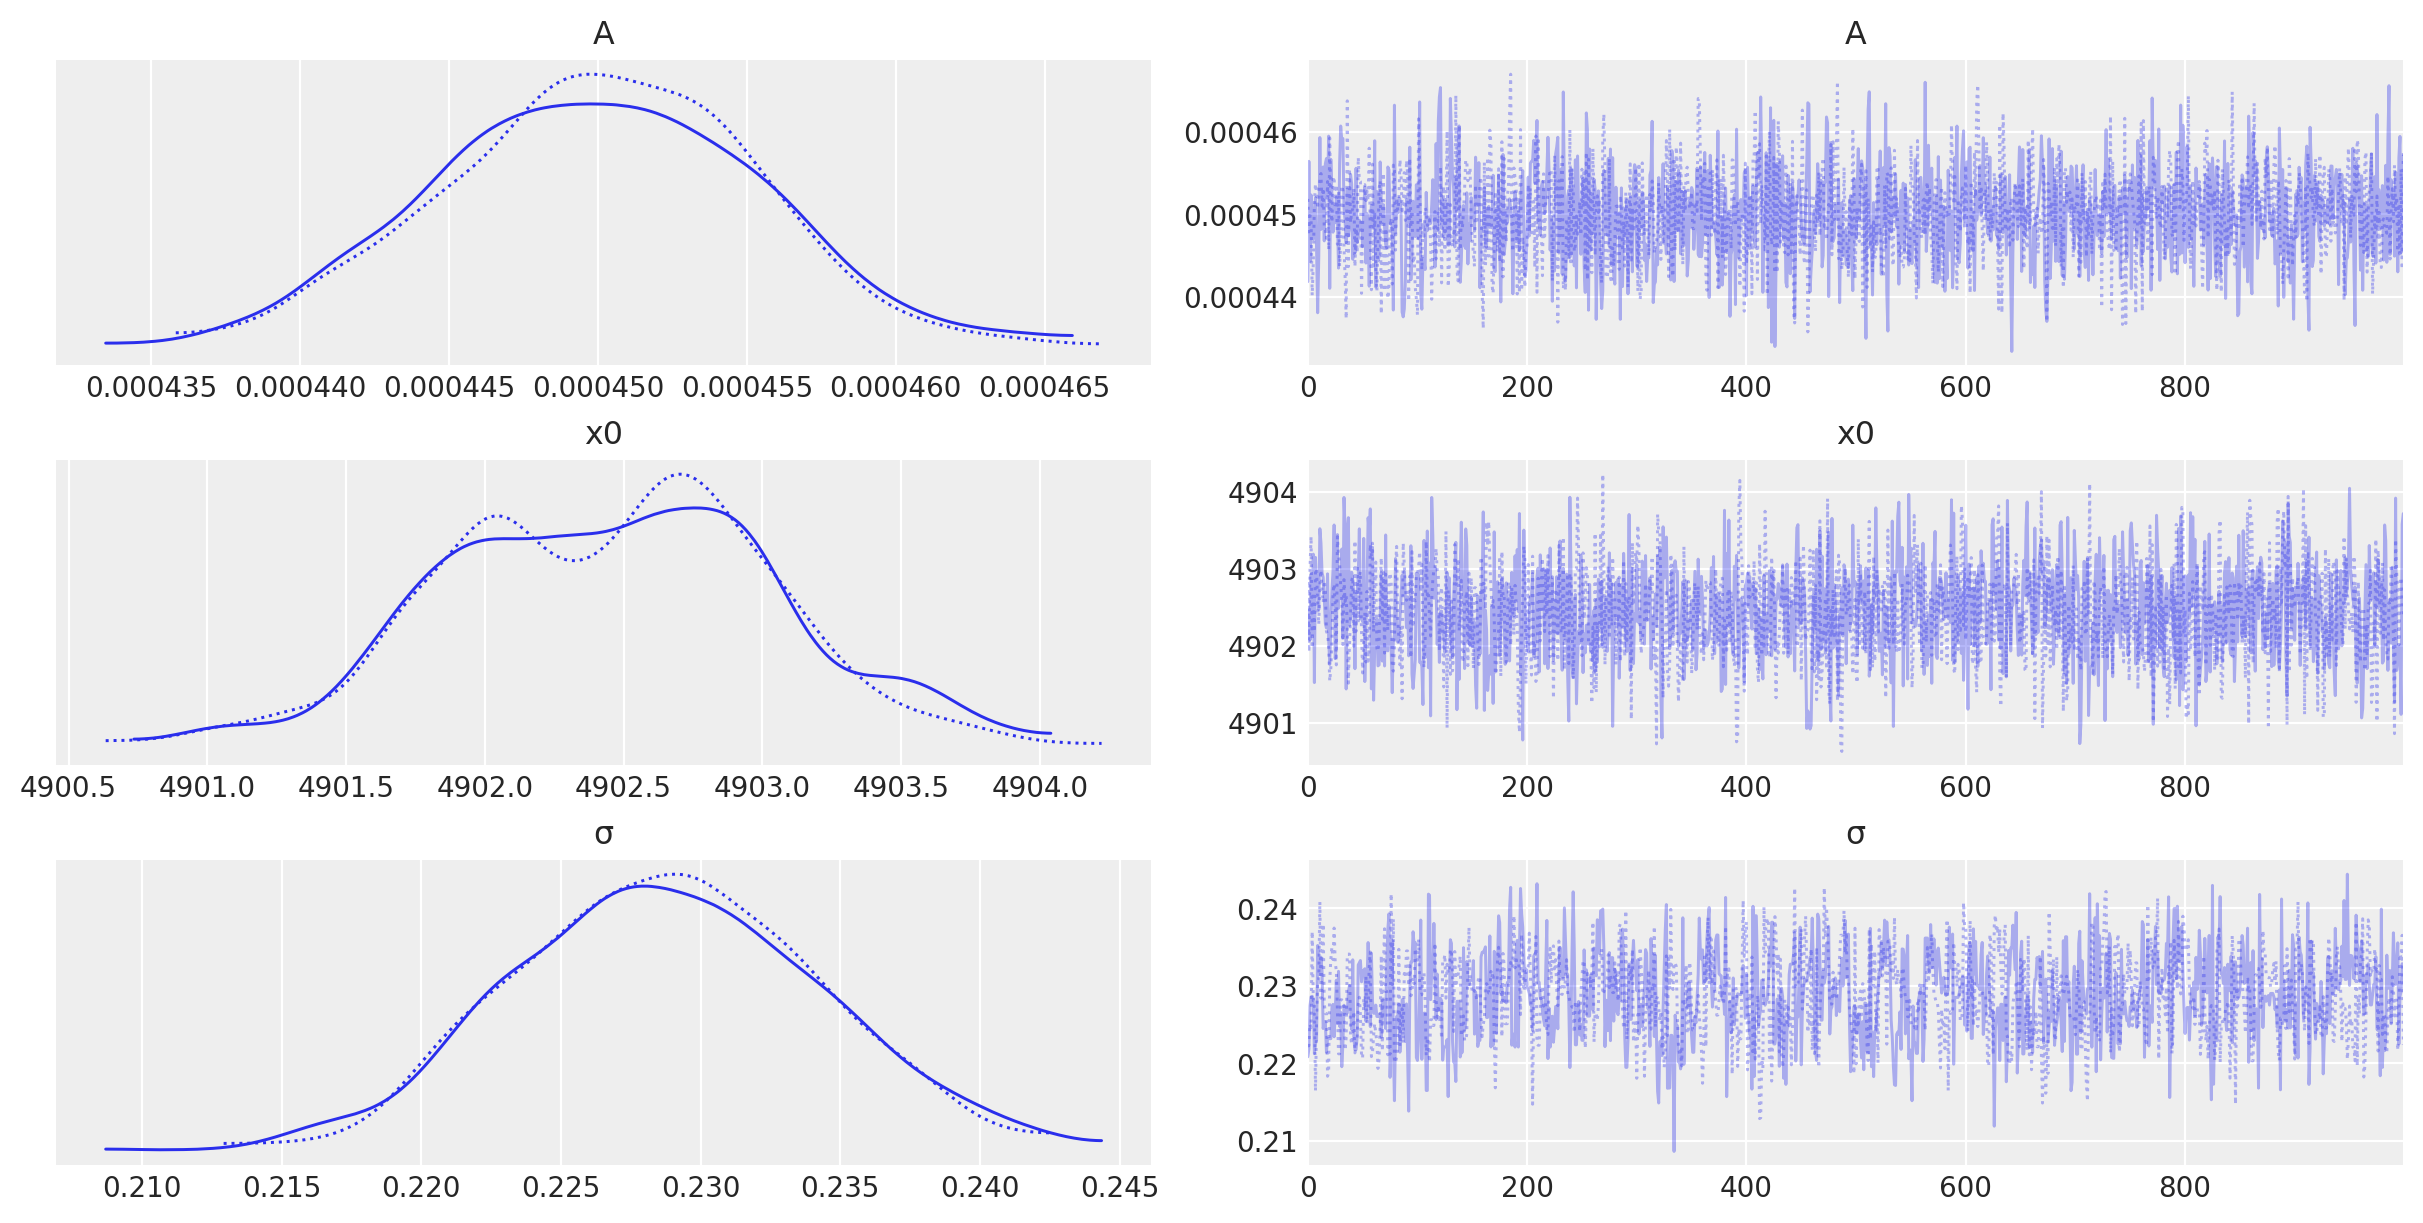

In [40]:
az.plot_trace(idata)

In [41]:
az.summary(idata)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
A       0.0   0.0     0.0      0.0        0.0      0.0    2039.0    1606.0   
x0 4902.443  0.61 4901.43 4903.727      0.014     0.01    1933.0    1423.0   
σ     0.229 0.005   0.219    0.239        0.0      0.0     796.0    1333.0   

    r_hat  
A     1.0  
x0    1.0  
σ     1.0

In [42]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l_smt = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u_smt = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

C:\Users\User\AppData\Local\Temp\ipykernel_3336\3769809511.py:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


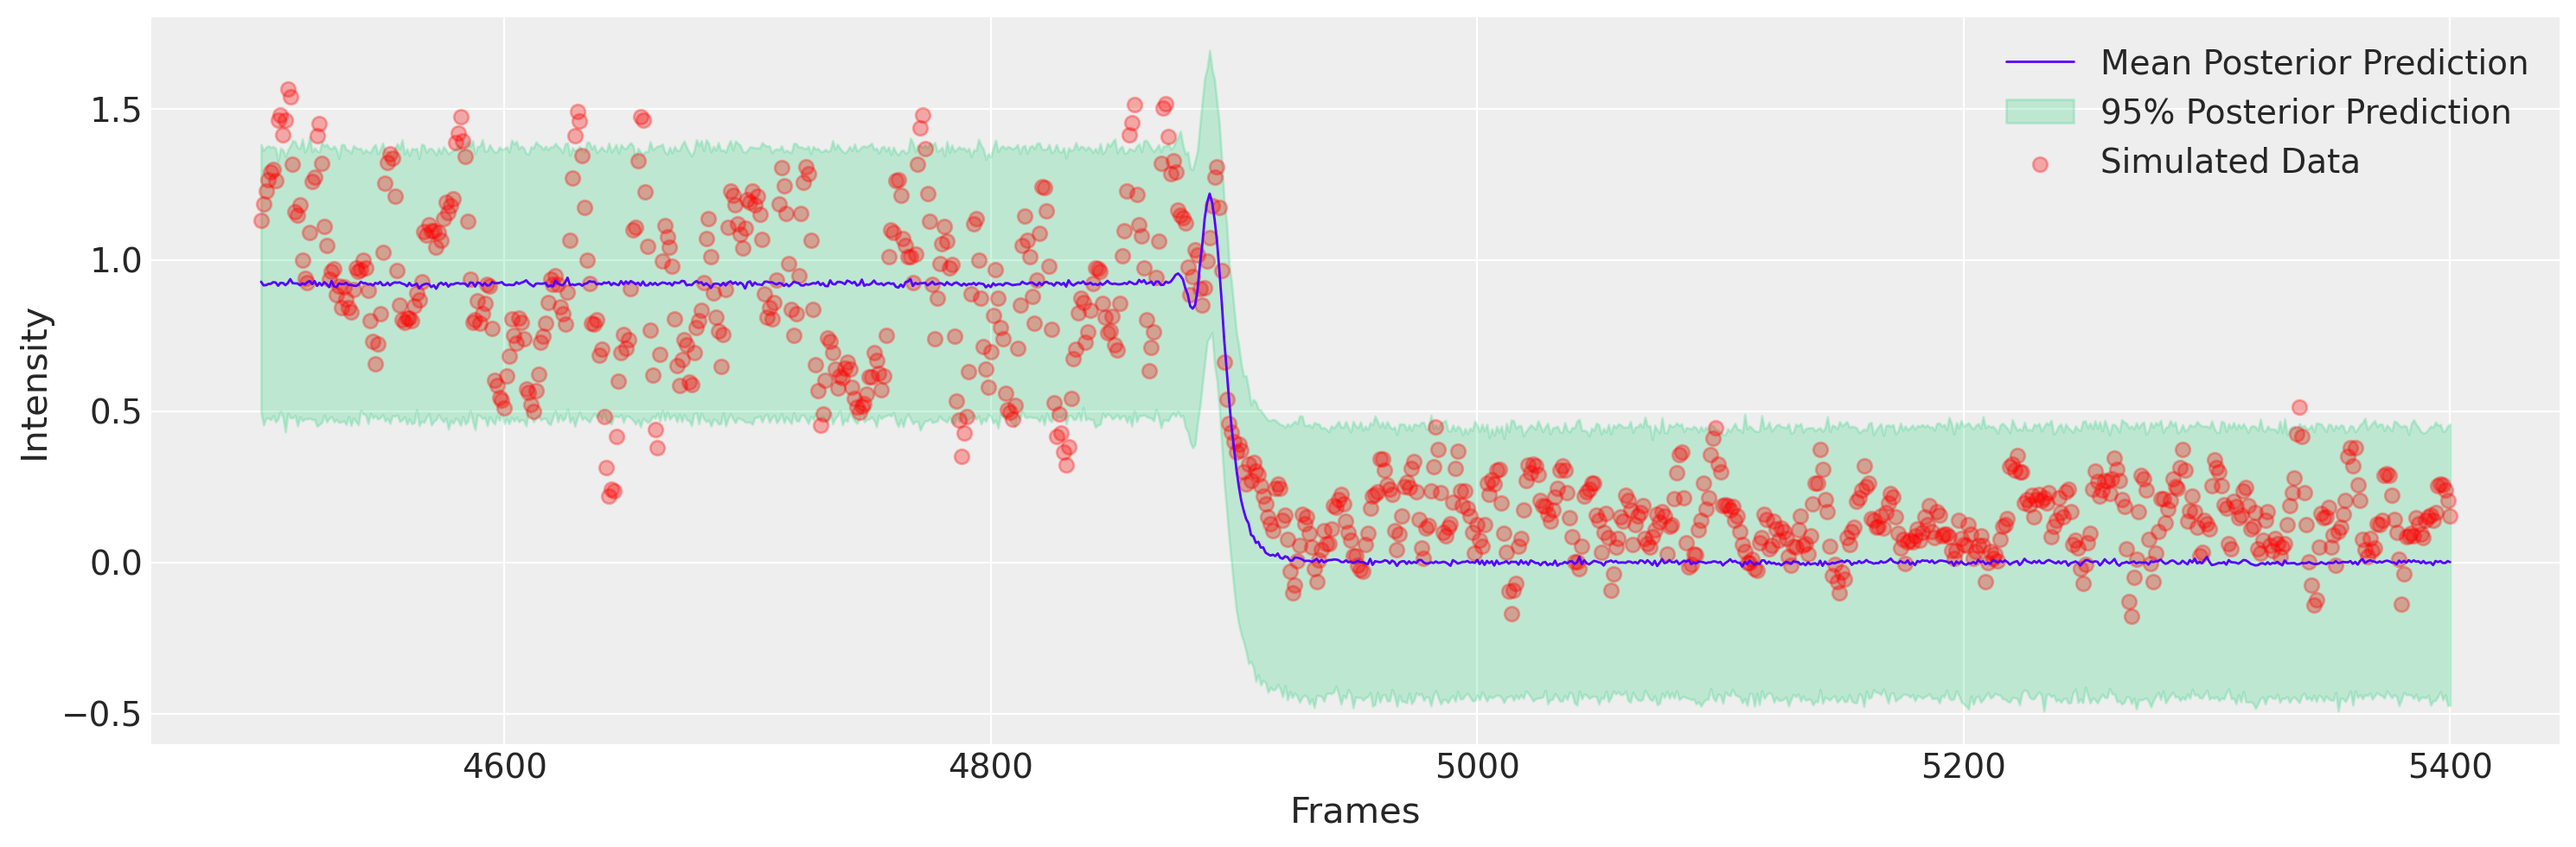

In [43]:
plt.figure(figsize=(15,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l_smt, crit_u_smt, alpha=0.2, color="#00cc66")
plt.scatter(x_data, y_filtered, c='r', marker='o', alpha=0.3)
# plt.plot(x_data, y_data, 'r-', lw=1, alpha=0.5)
plt.xlabel('Frames')
# plt.xlim(4900, 5200)
plt.ylabel('Intensity')
plt.tight_layout()
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], loc='upper right')
# plt.savefig('hasil-kurvatransmisi-planck.png', dpi=150)

### Konversi *frame number* ke waktu

Text(0, 0.5, 'Julian Date')

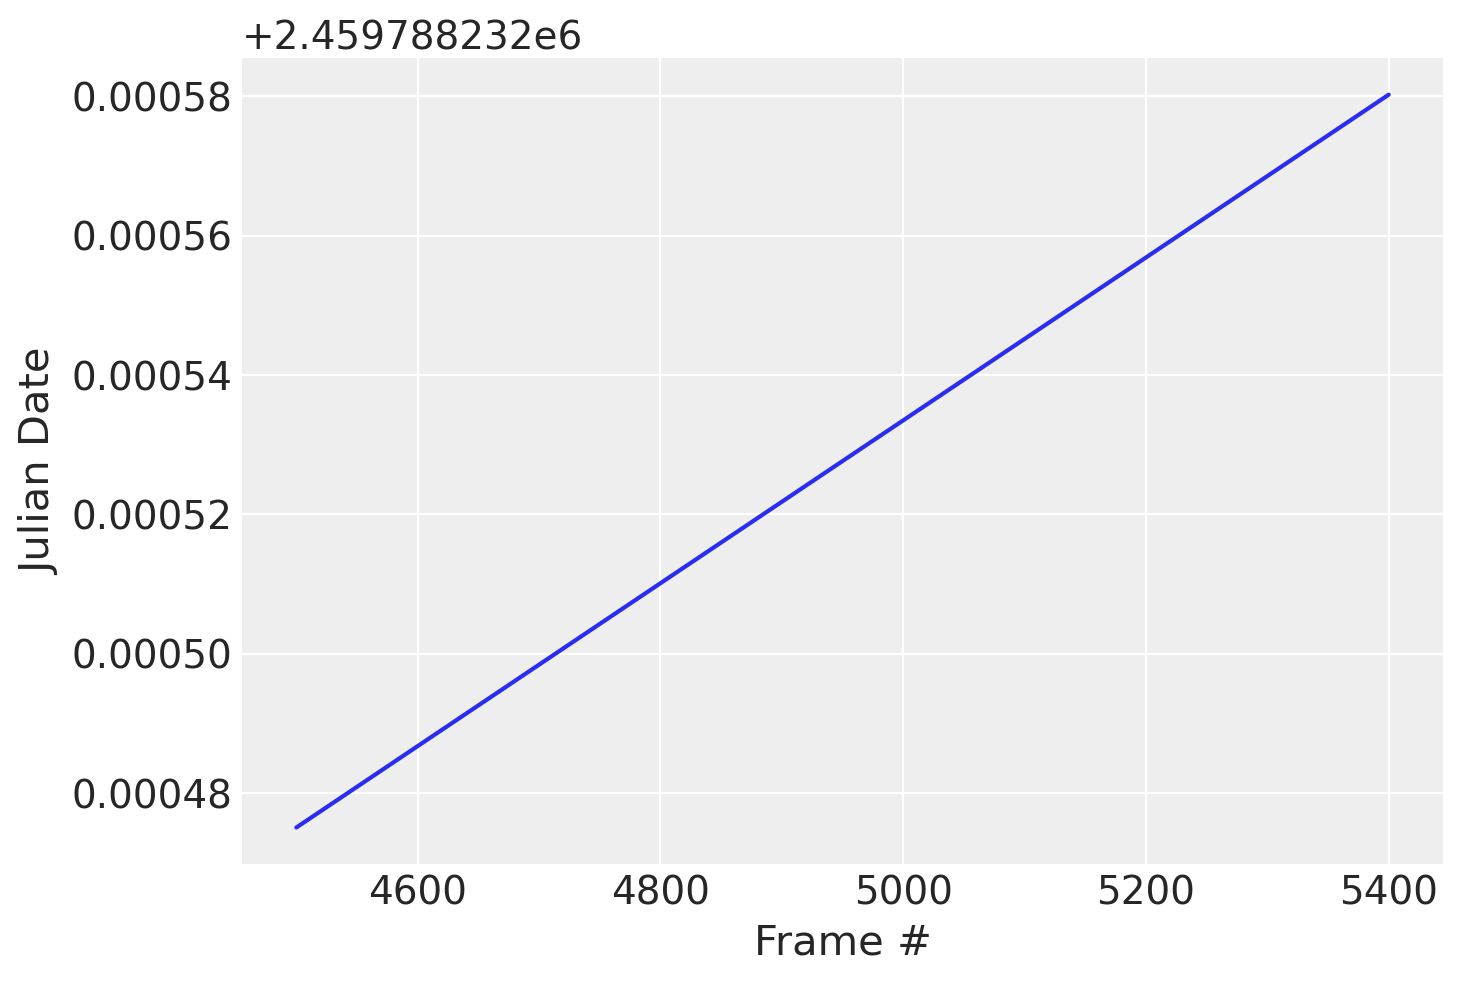

In [44]:
x = data_copy['Frame']
y = data_copy['JD']

plt.plot(x, y)
plt.xlabel('Frame #')
plt.ylabel('Julian Date')

In [45]:
f = interp1d(x, y, kind='cubic')

#### Ambil nilai dari `arviz inference data`

In [46]:
framenum = idata.posterior.mean().x0.values

# interpolasi

date = f(framenum)
type(date)

numpy.ndarray

### Ubah `ndarray` ke `str`

In [47]:
date_str = np.array_str(date)
date_str

'2459788.232522067'

In [48]:
# Ubah ke format waktu

j_date = Time(date_str, format='jd')
# j_date.value
iso_time = j_date.iso
iso_time

'2022-07-27 17:34:49.907'

### Ubah `str` ke format `timestamp`

In [49]:
t_iso_time = pd.to_datetime(iso_time)
t_iso_time

Timestamp('2022-07-27 17:34:49.907000')

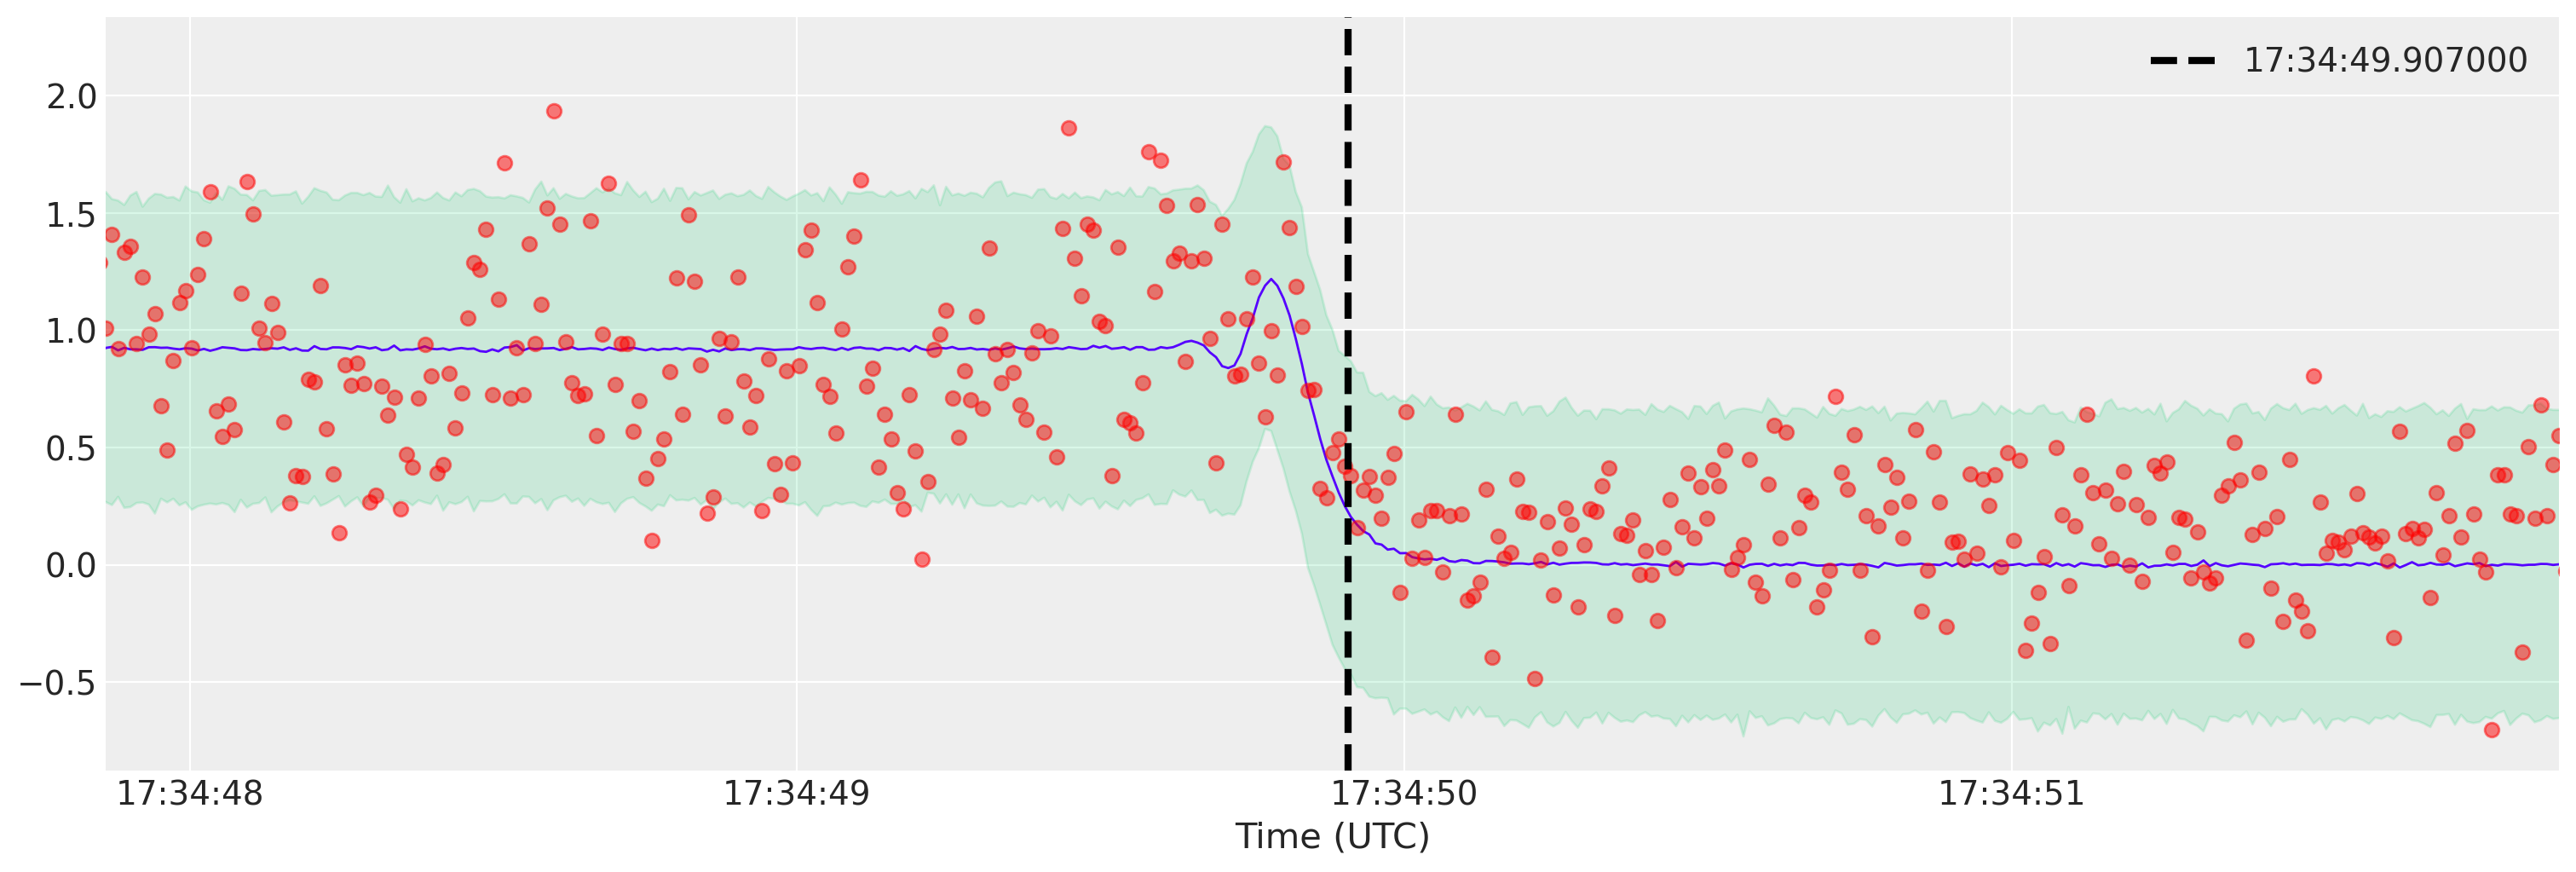

In [50]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(data_copy['Date'], mean_spp, linestyle='-', linewidth=1, color="#5500ff")
# ax.plot(data_copy['Time'], mean_spp, linestyle='-', linewidth=1, color="")
ax.fill_between(data_copy['Date'], crit_l, crit_u, alpha=0.15, color="#00cc66")
ax.plot(data_copy['Date'], value_scaled, 'ro', alpha=0.5)

plt.axvline(x = t_iso_time, color = 'k', lw=3, ls='--', label = t_iso_time.time())
plt.legend(loc = 'upper right')

#ax.plot(data['Frame'], data['Value'], 'ro', alpha=0.35)
# ax.set_xlabel('UTC (mm:ss.ssssss)')
ax.set_xlim(data_copy['Date'][200], data_copy['Date'][600]) # baris ke-# untuk kolom 'Time'
ax.set_xlabel('Time (UTC)')

date_form = mdates.DateFormatter("%H:%M:%S")#, tz=pytz.timezone(‘Australia/Sydney’))
#ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
#ax.xaxis.set_major_locator(mdates.HourLocator(byhour=None, interval=2))
ax.xaxis.set_major_formatter(date_form)
# ax.tick_params('x', labelrotation=45)

# data['Time'].dt.hour()

<AxesSubplot:xlabel='y_pred / y_pred'>

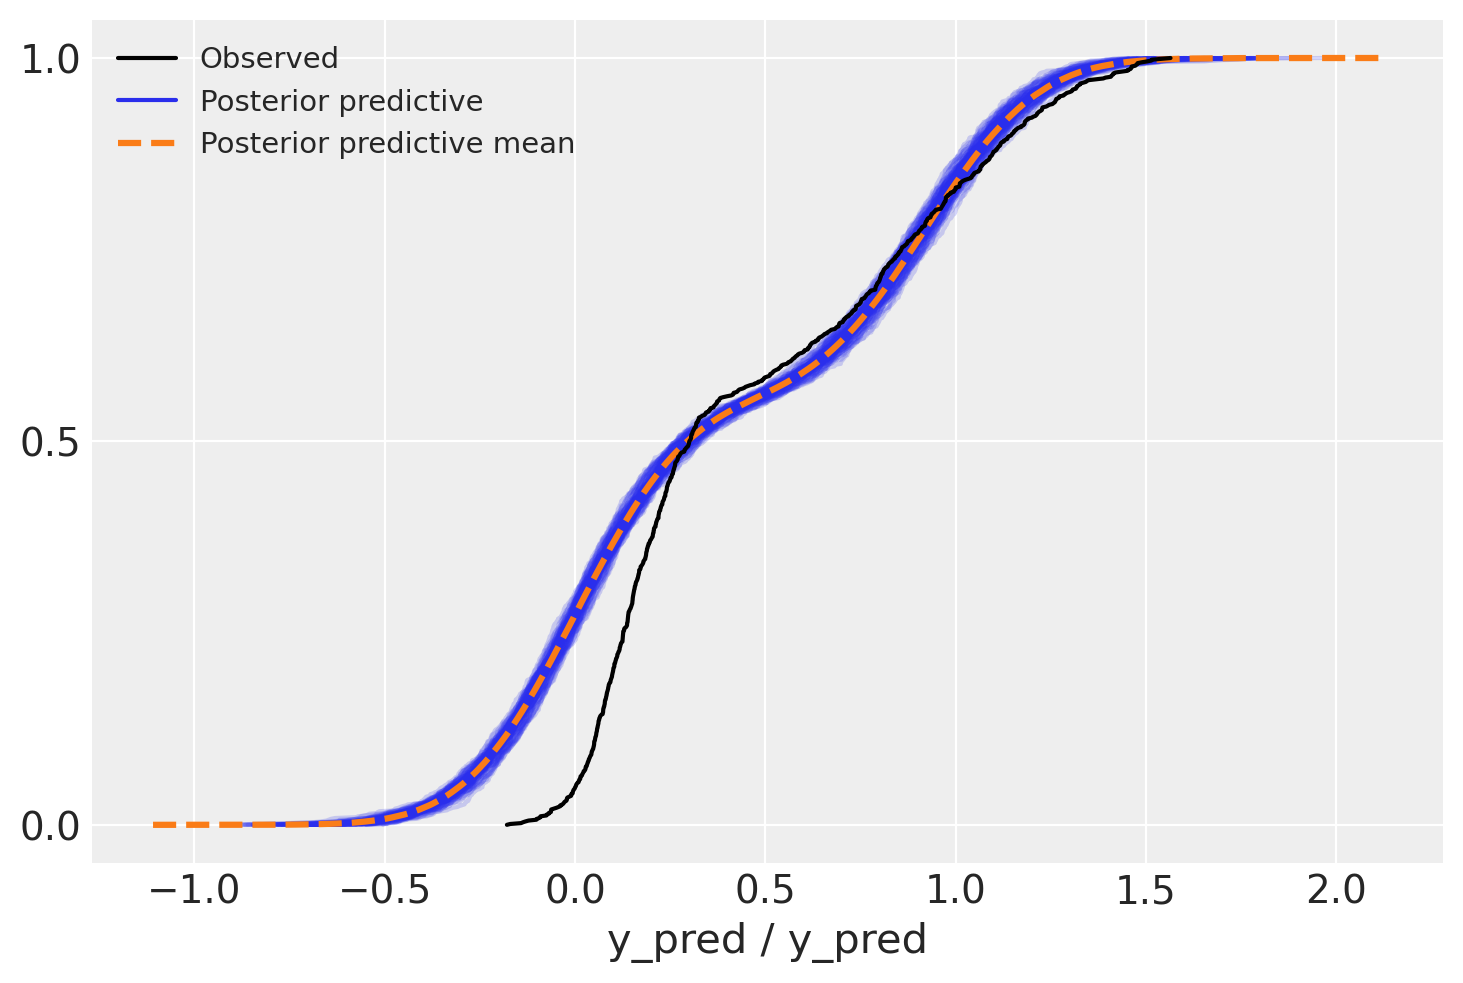

In [51]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')

<AxesSubplot:xlabel='y_pred / y_pred'>

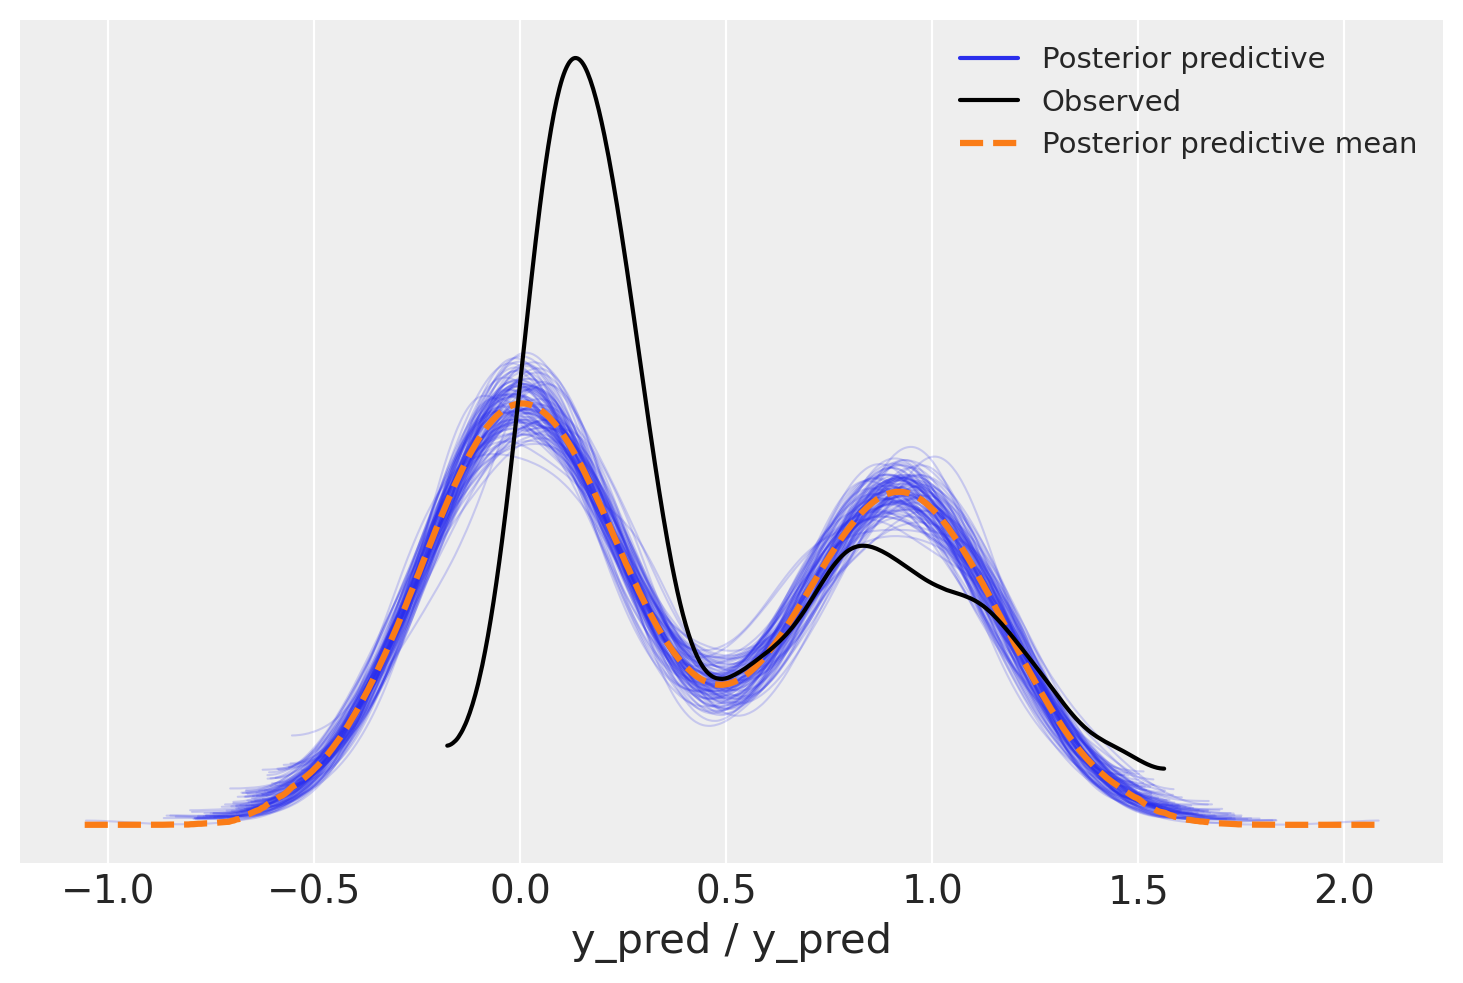

In [52]:
az.plot_ppc(idata, num_pp_samples=100)